In [ ]:
"""
this one should be used as a playground before anything changes at the HRL-LLM repository

this notebook should include the following:
- the LMM (class DisasterResponseAssistant)
- the SARenv class for the flat RL
- the SARenv class for the hierarchical RL
- the Q learning agent class
- the Q learning attention class
- the hierarchical Q learning class
- the hierarchical Q learning attention class
- rewards plot (4 plots in the same figure)
- policy evaluation
- visitation heatmap

The reason that we have two environments is because we have included the hierarchical process within the environment class and not 
within the agent class. But the functionality and parameters remain the same.

TODO:
1) each agent must evakuated across 10-20 runs and then average for rewards, policy, visitation 
2) include everything in one env class
"""

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm.auto import tqdm
import pandas as pd
from IPython.display import clear_output
import time
from PIL import Image
from io import BytesIO
import torch
from termcolor import colored
import matplotlib.colors as mcolors
import os
import gym
from gym import spaces

In [8]:
class GridWorldEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self):
        super(GridWorldEnv, self).__init__()
        self.action_space = spaces.Discrete(4)  # Up, Down, Left, Right for EXPLORE
        self.observation_space = spaces.MultiDiscrete([7, 7, 2, 2, 2, 2])  # x, y, Info collected X, info collected Y, info_collectedZ, Victim saved
        self.state = [4, 1, 0, 0, 0, 0]  # (x, y, info_collectedX, info_collectedY, info_collectedZ, victim_saved)
        self.info_location = [(4, 4), (6, 2), (5, 5)]
        self.final_location = (0, 3)
        self.current_option = 0  # Starting option will be decided by the manager
        self.grid_size = 7
        self.max_steps = self.grid_size * self.grid_size
        self.total_turns = 0

        self.winReward = 100  ## 118
        self.askingReward = 20
        self.exceedStepPenalty = -5
        self.turnPenalty = -1
        self.wrongAskPenalty = -5
        self.ditchPenalty = -30
        self.savePenalty = -5

        self.POIs, self.fires = [], []
        self.visited_information_state = False

        self.ditches = [(1, 6), (2, 2), (2, 4), (3, 2), (3, 3), (3, 4), (4, 5), \
                        (5, 0), (5, 1), (5, 2), (6, 0), (0, 2), (0, 4)]
        
        self.sensor_readings = {}
        
        self.keywords_for_POIs = ["victim", "trail", "potential sighting", "Screams", "shelter", "high ground", "water source",
                                  "access route", "last known position", "high probability area", "safe"]
        self.keywords_for_danger = ["fire", "heat", "smoke", "restricted", "no access allowed", "flames", "dangerous", "steep terrain",
                                    "dense vegetation", "unstable structures", "unstable buildings", "hazardous material", "unsafe"]

        self.locationsDict = {
            'hospital': (0, 3),
            'train station': (5, 6), ## (6, 5)
            'school': (3, 0),
            'mall': (4, 1),  # (1, 1)
            'bank': (6, 5),
            'restaurant': (2, 0),
            'shop': (1, 2)
        }
    

    ### Handles the 'ASK' action, providing the agent with environmental information
    def ask_action(self, state):
        x, y, info_collectedX, info_collectedY, info_collectedZ, victim_saved = state
        verbal_inputs = []
        if not info_collectedZ:
            # self.last_reward_state = (position, True) # Update the last_reward_state here upon successful information retrieval
            #print(f"last reward state {self.last_reward_state}")
            VERBAL_INPUT1 = "Hey, there's a victim at the hospital."
            VERBAL_INPUT2 = "Also, fire was reported at the train station."
            VERBAL_INPUT3 = "There is a fire at the bank."
            VERBAL_INPUT4 = "A safe area is the mall."
            VERBAL_INPUT5 = "Keep an eye on the access route in the school."
            VERBAL_INPUT6 = "Keep an eye on the access route in the restaurant."
            VERBAL_INPUT7 = "Keep an eye on the access route in the shop."
            verbal_inputs.append(VERBAL_INPUT1)
            verbal_inputs.append(VERBAL_INPUT2)
            verbal_inputs.append(VERBAL_INPUT3)
            verbal_inputs.append(VERBAL_INPUT4)
            verbal_inputs.append(VERBAL_INPUT5)
            verbal_inputs.append(VERBAL_INPUT6)
            verbal_inputs.append(VERBAL_INPUT7)
            for input_text in verbal_inputs:
                    self.simulate_LLM_process_alternative(input_text)
    
    ### Simulates the process of obtaining information from a language model (multiple locations)
    ### problem when two locations associated to different class are present in the smae sentence 
    def simulate_LLM_process_alternative(self, input):
        sum_embedding = torch.tensor([0, 0], dtype=torch.float32)
        locations_in_input = []
        for location in self.locationsDict:
            # Check if the location keyword is in the information string
            if location in input:
                location_embedding = torch.tensor(self.locationsDict[location], dtype=torch.float32)
                sum_embedding += location_embedding
                locations_in_input.append(tuple(int(x) for x in location_embedding.tolist()))
        #return locations_in_input
        if locations_in_input:
            #print(f"response is {locations_in_input} -- when input is: {input}")
            self.visited_information_state = True
            #print(f"response is {response}")
            sentences = input.split(". ") if ". " in input else [input]
            #print(f"the sentences are: {sentences}")
            for sentence in sentences:
                is_poi = any(keyword in sentence for keyword in self.keywords_for_POIs)
                is_fire = any(keyword in sentence for keyword in self.keywords_for_danger)
                #print(f"In sentence '{sentence}' we have POI: {is_poi} and fire: {is_fire}")
                for location, location_coords in self.locationsDict.items():
                    if location in sentence:
                        info = tuple(int(x) for x in torch.tensor(location_coords, dtype=torch.float32).tolist())
                        #print(f"info now is {info} and poi {is_poi} and fire {is_fire}")
                        # If the location is already categorized, skip it
                        if info in self.POIs or info in self.fires:
                            continue
                        # Add location to POIs or fires based on the context of the sentence
                        self.update_environment(info, is_poi, is_fire)
    
    def update_environment(self, info, is_poi, is_fire):
        if is_poi and not is_fire:
            self.sensor_readings[(info[0], info[1], 1, 1, 1, 0)] = 10.0
            self.POIs.append(info)
        elif is_fire and not is_poi:
            self.sensor_readings[(info[0], info[1], 1, 1, 1, 0)] = -10.0
            self.fires.append(info)
    
    def next_state_vision(self, target, action):
        x, y, _, _, _, _ = target
        if action == 0:  # Up
            x = max(x - 1, 0)
        elif action == 1:  # Down
            x = min(x + 1, self.grid_size - 1)
        elif action == 2: # Left
            y = max(y - 1, 0)
        elif action == 3:  # Right
            y = min(y + 1, self.grid_size - 1)
        next_position_x, next_position_y = x, y
        return (next_position_x, next_position_y)

    def step(self, action):
        x, y, info_collectedX, info_collectedY, info_collectedZ, victim_saved = self.state
        reward = self.turnPenalty  # Small penalty for each step
        done = False
        self.total_turns += 1
        if self.total_turns >= self.max_steps:
            reward += self.exceedStepPenalty  ## (-5)
            done = True
            self.current_option = 0

        if self.current_option == 0: ## EXPLORE
            if (tuple([x, y]) != self.info_location[0] and not info_collectedX) or (tuple([x, y]) != self.info_location[1] and not info_collectedY and info_collectedX) or (tuple([x, y]) != self.info_location[2] and not info_collectedZ and info_collectedX and info_collectedY):  # EXPLORE (heading to info location X)
                if action == 0:  # Up
                    x = max(x - 1, 0)
                elif action == 1:  # Down
                    x = min(x + 1, self.grid_size - 1)
                elif action == 2: # Left
                    y = max(y - 1, 0)
                elif action == 3:  # Right
                    y = min(y + 1, self.grid_size - 1)
            if (tuple([x, y]) == self.info_location[0] and not info_collectedX) or (tuple([x, y]) == self.info_location[1] and not info_collectedY and info_collectedX) or (tuple([x, y]) == self.info_location[2] and not info_collectedZ and info_collectedX and info_collectedY): ## switch to COLLECT
                self.current_option = 1
                
            if tuple([x, y]) != self.final_location and info_collectedX and info_collectedY and info_collectedZ: ## EXPLORE (heading to final location)
                if action == 0:  # Up
                    x = max(x - 1, 0)
                elif action == 1:  # Down
                    x = min(x + 1, self.grid_size - 1)
                elif action == 2: # Left
                    y = max(y - 1, 0)
                elif action == 3:  # Right
                    y = min(y + 1, self.grid_size - 1)
            if tuple([x, y]) == self.final_location and info_collectedX and info_collectedY and info_collectedZ: ## switch to SAVE
                self.current_option = 2
                
            if tuple([x, y]) in self.ditches:
                reward += self.ditchPenalty  ## (-20)
                done = True
                self.current_option = 0
            
        
        elif self.current_option == 1:
            if tuple([x, y]) == self.info_location[0]:
                if action == 0:  # Assume action 0 is "getX"
                    if not info_collectedX:
                        info_collectedX = 1
                        # reward += self.askingReward  # Reward for collecting the info for the first time
                    else:
                        pass
                        # reward += self.wrongAskPenalty  # Penalty for attempting to collect again
                    self.current_option = 0  # Switch back to EXPLORE after collection attempt

            if tuple([x, y]) == self.info_location[1]:
                if action == 1:  # Assume action 1 is "getY"
                    if not info_collectedY and info_collectedX:
                        # self.ask_action(self.state)
                        info_collectedY = 1
                        # reward += self.askingReward  # Reward for collecting the info for the first time
                    else:
                        pass
                        # reward += self.wrongAskPenalty  # Penalty for attempting to collect again
                    self.current_option = 0  # Switch back to EXPLORE after collection attempt
            
            if tuple([x, y]) == self.info_location[2]:
                if action == 2:  # Assume action 2 is "getZ"
                    if not info_collectedZ and info_collectedX and info_collectedY:
                        self.ask_action(self.state)
                        info_collectedZ = 1
                        # reward += self.askingReward  # Reward for collecting the info for the first time
                    else:
                        pass
                        # reward += self.wrongAskPenalty  # Penalty for attempting to collect again
                    self.current_option = 0  # Switch back to EXPLORE after collection attempt
            

        elif self.current_option == 2:
            if tuple([x, y]) == self.final_location:
                if action == 0 and info_collectedX and info_collectedY and info_collectedZ:  # Assume action 0 is "save"
                    if not victim_saved:
                        victim_saved = 1
                        reward += self.winReward  # High reward for saving the victim
                        done = True
                    else:
                        reward += self.savePenalty # Penalty for redundant saving
                else:
                    reward += self.savePenalty  # Penalty if save action is taken without collected info or at wrong location


        self.state = [x, y, info_collectedX, info_collectedY,info_collectedZ, victim_saved]
        return self.state, reward, done, {}

    def reset(self):
        self.total_turns = 0
        self.POIs = []
        self.fires = []
        self.visited_information_state = False
        self.state = [4, 1, 0, 0, 0, 0]
        self.current_option = 0  # Start with EXPLORE
        return self.state

    def render(self, mode='human'):
        grid = np.zeros((7, 7), dtype=int)
        x, y, _, _ = self.state
        grid[y, x] = 1
        print("Current Grid:\n", grid)


env = GridWorldEnv()

In [11]:
class QLearningAgent:
    def __init__(self, state_space, action_space, learning_rate=0.1, discount_factor=0.998, epsilon=0.01, epsilon_decay=0.995, min_epsilon=0.01, decay_rate=2):
        self.q_table = np.zeros((state_space, action_space))
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self.decay_rate = decay_rate

    def choose_action(self, state, evaluation=False):
        state_index = self.state_to_index(state)
        if evaluation or np.random.rand() > self.epsilon:
            return np.argmax(self.q_table[state_index])
        else:
            return np.random.randint(0, self.q_table.shape[1])

    def update(self, state, action, reward, next_state):
        state_index = self.state_to_index(state)
        next_state_index = self.state_to_index(next_state)
        best_next_action = np.argmax(self.q_table[next_state_index])
        td_target = reward + self.discount_factor * self.q_table[next_state_index][best_next_action]
        td_error = td_target - self.q_table[state_index][action]
        self.q_table[state_index][action] += self.learning_rate * td_error
        # self.epsilon = max(self.epsilon * self.epsilon_decay, self.min_epsilon)

    def state_to_index(self, state):
        # Convert state to index for the Q-table
        # return np.dot(state, [1, 17, 289, 578, 1156])  # Example for a hierarchical indexing (17x17)
        return np.dot(state, [1, 7, 49, 98, 196, 392])  # Example for a hierarchical indexing

    def decay_epsilon(self, episodes):
        if self.epsilon > 0.1:
            self.epsilon -= self.decay_rate / episodes
        else:
            self.epsilon = self.min_epsilon
        return self.epsilon


def train(env, workers, num_episodes=1500):
    total_rewards = np.zeros(num_episodes)
    Rewards = 0
    for episode in range(num_episodes):
        # print(f"Starting Episode {episode + 1}")
        if episode % 250 == 0:    
            print(f"Episode: {episode}, Total Reward: {Rewards}, Exploration Rate: {explore_worker.epsilon}")

        total_reward, Rewards = 0, 0
        state = env.reset()
        done = False
        step_count = 0
        while not done:
            option = env.current_option  # Get current option from the environment
            worker = workers[option]  # Choose the correct worker for the option
            action = worker.choose_action(state)  # Worker decides the action
            next_state, reward, done, _ = env.step(action)  # Execute the action in the environment
            Rewards += reward
            # Update the worker's Q-table
            worker.update(state, action, reward, next_state)
            manager.update(state, option, reward, next_state)

            # Print the details of the current step
            # print(f"  Step {step_count + 1}: State {state}, Option {option}, Action {action}, Reward {reward}, Next State {next_state}")
            
            # Move to the next state
            state = next_state
            total_reward += reward
            step_count += 1
        total_rewards[episode] = Rewards
        manager.epsilon = manager.decay_epsilon(num_episodes)
        explore_worker.epsilon = explore_worker.decay_epsilon(num_episodes)
        collect_worker.epsilon = collect_worker.decay_epsilon(num_episodes)
        save_worker.epsilon = save_worker.decay_epsilon(num_episodes)
        # print(f"Episode {episode + 1} finished. Total steps = {step_count}, Total Reward = {total_reward}")
    
    return total_rewards, workers

# Manager for choosing options
manager = QLearningAgent(1527, 3)  # State space size 5*5*2*2, 3 options
# Assuming QLearningAgent is defined elsewhere with methods for choose_action and update
explore_worker = QLearningAgent(1527, 4)  # Up, down, left, right
collect_worker = QLearningAgent(1527, 6)  # getX, getY, 
save_worker = QLearningAgent(1527, 4)  # Only save

workers = {
    0: explore_worker,  # Worker for EXPLORE
    1: collect_worker,  # Worker for COLLECT
    2: save_worker       # Worker for SAVE
}



In [12]:
all_total_rewards_AGENT_hier = []  # List to store total rewards from each run
for _ in range(1):
    env = GridWorldEnv()
    # Manager for choosing options
    # Manager for choosing options
    manager = QLearningAgent(1527, 3)  # State space size 5*5*2*2, 3 options
    # Assuming QLearningAgent is defined elsewhere with methods for choose_action and update
    explore_worker = QLearningAgent(1527, 4)  # Up, down, left, right
    collect_worker = QLearningAgent(1527, 6)  # getX, getY, 
    save_worker = QLearningAgent(1527, 4)  # Only save

    workers = {
        0: explore_worker,  # Worker for EXPLORE
        1: collect_worker,  # Worker for COLLECT
        2: save_worker       # Worker for SAVE
    }
    hier_returns, workers_simple = train(env, workers, num_episodes=1500)
    all_total_rewards_AGENT_hier.append(hier_returns)
    
avg_total_rewards_AGENT_hier = np.mean(all_total_rewards_AGENT_hier, axis=0)

# hier_returns, workers_simple = train(env, workers, num_episodes=1500)

Episode: 0, Total Reward: 0, Exploration Rate: 0.01
Episode: 250, Total Reward: 67, Exploration Rate: 0.01
Episode: 500, Total Reward: 75, Exploration Rate: 0.01
Episode: 750, Total Reward: -50, Exploration Rate: 0.01
Episode: 1000, Total Reward: 76, Exploration Rate: 0.01
Episode: 1250, Total Reward: 76, Exploration Rate: 0.01


In [ ]:
class QLearningAgent_attention:
    def __init__(self, state_space, action_space, learning_rate=0.1, discount_factor=0.998, epsilon=1.0, epsilon_decay=0.995, min_epsilon=0.01, decay_rate=2):
        self.q_table = np.zeros((state_space, action_space))
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self.decay_rate = decay_rate
        self.attention_space_low = np.zeros((state_space, action_space))
        self.received_input = False
    
    ### Identifies states that have changed based on sensor readings.
    def identify_changed_states(self, readings):
        changed_states = [i for i, value in readings.items() if value != 1]
        return changed_states

    ### Finds states connected to a given target state, considering possible actions and their inverse
    def get_connected_states(self, target_state):
        # Inverse action mapping for movement actions
        inverse_actions = {0: 1, 1: 0, 2: 3, 3: 2}
        # Generate state-action pairs
        connected_states_pairs = []
        for action in range(self.q_table.shape[1]):
            inverse_action = inverse_actions[action]
            possible_prev_state = env.next_state_vision(target_state, inverse_action)
            # print(possible_prev_state)
            # Check if the resulting state is valid and leads to the target state
            if possible_prev_state != tuple([target_state[0], target_state[1]]) and possible_prev_state not in env.ditches:
                connected_states_pairs.append((possible_prev_state, action))
        return connected_states_pairs
    
    ### Updates the attention space, which influences the agent's decision-making based on environmental changes.
    def update_attention_space(self, connection, readings):
        connected_states = self.get_connected_states(connection)
        # Determine the value to add based on sensor reading
        value_to_add = 2.0 if readings[connection] > 0 else -100.0
        for connected_state, action in connected_states:
            # print(connected_state)
        # Update the attention space value for the state-action pair
            updated_state = [connected_state[0], connected_state[1], 1, 1, 1, 0]
            updated_state_index = self.state_to_index(updated_state)
            self.attention_space_low[updated_state_index][action] = value_to_add
        # # Check if the new information refers to a victim state and update exclusively for SAVE action
        if tuple([connection[0], connection[1]]) == env.final_location:
            updated_victim_state = [connection[0], connection[1], 1, 1, 1, 0]
            updated_victim_state_index = self.state_to_index(updated_victim_state)
            self.attention_space_low[updated_victim_state_index][0] = 100
            ##  action 'save' is highly favored in the Q-table when the agent is at the final location, guiding the save_worker to prioritize this action.
        return self.attention_space_low
    
    def apply_attention_to_q_table(self):
        for index, action_values in np.ndenumerate(self.attention_space_low):
            state_index, action = index
            if action_values != 0:
                self.q_table[state_index][action] = action_values
                
    
    def choose_action(self, state, evaluation=False):
        state_index = self.state_to_index(state)
        if not env.visited_information_state:
            if evaluation or np.random.rand() > self.epsilon:
                return np.argmax(self.q_table[state_index])
            else:
                return np.random.randint(0, self.q_table.shape[1])
        else:
            return np.argmax(self.q_table[state_index])
            

    def update(self, state, action, reward, next_state):
        state_index = self.state_to_index(state)
        next_state_index = self.state_to_index(next_state)
        best_next_action = np.argmax(self.q_table[next_state_index])
        td_target = reward + self.discount_factor * self.q_table[next_state_index][best_next_action]
        td_error = td_target - self.q_table[state_index][action]
        self.q_table[state_index][action] += self.learning_rate * td_error
        # self.epsilon = max(self.epsilon * self.epsilon_decay, self.min_epsilon)

    def state_to_index(self, state):
        # Convert state to index for the Q-table
        return np.dot(state, [1, 7, 49, 98, 196, 392])  # Example for a hierarchical indexing

    def decay_epsilon(self, episodes):
        if self.epsilon > 0.1:
            self.epsilon -= self.decay_rate / episodes
        else:
            self.epsilon = self.min_epsilon
        return self.epsilon
    
    def decay_epsilon_exploit(self, episodes):
        if self.epsilon > 0.1:
            self.epsilon -= (8*self.decay_rate) / episodes
        else:
            self.epsilon = self.min_epsilon
        return self.epsilon


def train(env, workers, num_episodes=1500):
    total_rewards = np.zeros(num_episodes)
    Rewards = 0
    attention_space = {}
    stop_for_inspection = False  
    for episode in range(num_episodes):
        # print(f"Starting Episode {episode + 1}")
        if episode % 250 == 0:    
            print(f"Episode: {episode}, Total Reward: {Rewards}, Exploration Rate: {explore_worker.epsilon}")

        total_reward, Rewards = 0, 0
        state = env.reset()
        done = False
        step_count = 0
        while not done:
            if env.visited_information_state and not manager.received_input:
                identified_states = manager.identify_changed_states(env.sensor_readings)
                manager.received_input = True
                print(f"Got the info needed at ep {episode} and location {tuple([state[0], state[1]])}")
                if identified_states:
                    # print(f"identified states: {identified_states}")
                    for each_state in identified_states:
                        if tuple([each_state[0], each_state[1]]) != env.final_location: 
                            attention_space = explore_worker.update_attention_space(each_state, env.sensor_readings)
                            explore_worker.apply_attention_to_q_table()  # Update the Q-table of the explorer worker
                        else:
                            attention_space = save_worker.update_attention_space(each_state, env.sensor_readings)
                            save_worker.apply_attention_to_q_table()  # Update the Q-table of the save worker
                        stop_for_inspection = True
            # if stop_for_inspection:
            #     print("Stopping the simulation to check the Q tables")
            #     return workers, attention_space
                
            option = env.current_option  # Get current option from the environment
            worker = workers[option]  # Choose the correct worker for the option
            action = worker.choose_action(state)  # Worker decides the action
            next_state, reward, done, _ = env.step(action)  # Execute the action in the environment
            Rewards += reward
            # Update the worker's Q-table
            worker.update(state, action, reward, next_state)
            manager.update(state, option, reward, next_state)

            # Print the details of the current step
            # print(f"  Step {step_count + 1}: State {state}, Option {option}, Action {action}, Reward {reward}, Next State {next_state}")
            
            # Move to the next state
            state = next_state
            total_reward += reward
            step_count += 1
        total_rewards[episode] = Rewards
        if not env.visited_information_state:
            for w in workers.values():
                w.decay_epsilon(num_episodes)
        else:
            for w in workers.values():
                w.decay_epsilon_exploit(num_episodes)
        # manager.epsilon = manager.decay_epsilon(num_episodes)
        # explore_worker.epsilon = explore_worker.decay_epsilon(num_episodes)
        # collect_worker.epsilon = collect_worker.decay_epsilon(num_episodes)
        # save_worker.epsilon = save_worker.decay_epsilon(num_episodes)
        # print(f"Episode {episode + 1} finished. Total steps = {step_count}, Total Reward = {total_reward}")
    
    return total_rewards, attention_space, workers

# Manager for choosing options
manager = QLearningAgent_attention(1527, 3)  # State space size 5*5*2*2, 3 options
# Assuming QLearningAgent is defined elsewhere with methods for choose_action and update
explore_worker = QLearningAgent_attention(1527, 4)  # Up, down, left, right
collect_worker = QLearningAgent_attention(1527, 6)  # getX, getY, 
save_worker = QLearningAgent_attention(1527, 4)  # Only save

workers = {
    0: explore_worker,  # Worker for EXPLORE
    1: collect_worker,  # Worker for COLLECT
    2: save_worker       # Worker for SAVE
}

"""This setup ensures that the attention mechanism's outputs 
are integrated into the Q-learning process, allowing the agents to adaptively focus 
on areas of interest based on new environmental information. 
Each agent's Q-table is dynamically updated based on these attention adjustments, 
and the training process reflects these changes in real-time to enhance decision-making."""

In [ ]:
all_total_rewards_AGENT_hier_att = []  # List to store total rewards from each run
for _ in range(20):
    env = GridWorldEnv()
    # Manager for choosing options
    manager = QLearningAgent_attention(1527, 3)  # State space size 5*5*2*2, 3 options
    # Assuming QLearningAgent is defined elsewhere with methods for choose_action and update
    explore_worker = QLearningAgent_attention(1527, 4)  # Up, down, left, right
    collect_worker = QLearningAgent_attention(1527, 6)  # getX, getY, 
    save_worker = QLearningAgent_attention(1527, 4)  # Only save
    workers = {
    0: explore_worker,  # Worker for EXPLORE
    1: collect_worker,  # Worker for COLLECT
    2: save_worker       # Worker for SAVE
}
    hier_att_returns, attention, workers = train(env, workers, num_episodes=1500)
    all_total_rewards_AGENT_hier_att.append(hier_att_returns)
    
avg_total_rewards_AGENT_hier_att = np.mean(all_total_rewards_AGENT_hier_att, axis=0)

# hier_att_returns, attention, workers = train(env, workers, num_episodes=1500)

In [ ]:
def plot_learning_curve(total_rewards_list, EPISODES, labels, colors, optimal_reward):
    fig, ax = plt.subplots(figsize=(5, 4))
    for i, total_rewards in enumerate(total_rewards_list):
        mean_rewards_1, mean_rewards_50 = np.zeros(EPISODES), np.zeros(EPISODES)
        for t in range(EPISODES):
            mean_rewards_1[t] = np.mean(total_rewards[max(0, t-5):(t+1)])
            mean_rewards_50[t] = np.mean(total_rewards[max(0, t-100):(t+1)])
        ax.plot(mean_rewards_50, label=f'{labels[i]}', alpha=0.9, color=colors[i])
        ax.fill_between(range(EPISODES), mean_rewards_1, mean_rewards_50, color=colors[i], alpha=0.15)
        # Check for 20 consecutive iterations with reward >= optimal reward
        for t in range(EPISODES - 10):
            if all(total_rewards[t:t+10] >= optimal_reward):
                # ax.axvline(x=t+10, color=colors[i], linestyle='dotted')
                print(f"Line appears at episode: {t+10} for agent {labels[i]}")
                break
    # ax.axhline(y=optimal_reward, color='green', linestyle='--', label='Optimal Reward')
    ax.axhline(y=optimal_reward, color='black', linestyle='--', label='Optimal Reward', linewidth=0.8)
    ax.legend(fontsize=8, loc='best')
    ax.grid(True, color="white", linestyle='-', alpha=0.9)
    # Define a fainter lavender by adding an alpha value
    faint_lavender = mcolors.to_rgba('slategrey', alpha=0.2)  # Adjust alpha as needed
    ax.set_facecolor(faint_lavender)
    plt.xlabel("Episodes")
    plt.xticks(np.arange(0, EPISODES, step=250))
    # plt.yscale('symlog')  # 'symlog' handles negative values as well as positive values

    plt.ylabel("Avg. Total Rewards")
    plt.title("SAR GridWorld (7x7) - sparse reward")
    for spine in ax.spines.values():
        spine.set_visible(False)
    plt.show()
labels = ["Flat", "Flat-Attention", "HRL", "HRL-Attention"]
colors = ["blue", "chocolate", "magenta", "green"]
total_rewards_list = [avg_total_rewards_AGENT_flat, avg_total_rewards_AGENT_flat_att, avg_total_rewards_AGENT_hier, avg_total_rewards_AGENT_hier_att]#, avg_total_rewards_AGENT_1_ATTENTION]
plot_learning_curve(total_rewards_list, 1500, labels, colors, optimal_reward=92)

In [ ]:
import matplotlib.pyplot as plt

def plot_learning_curve(total_rewards_list, EPISODES, labels, colors, optimal_reward):
    fig, ax = plt.subplots(figsize=(5, 4))
    for i, total_rewards in enumerate(total_rewards_list):
        mean_rewards_1, mean_rewards_50 = np.zeros(EPISODES), np.zeros(EPISODES)
        max_rewards, min_rewards = np.zeros(EPISODES), np.zeros(EPISODES)
        for t in range(EPISODES):
            mean_rewards_50[t] = np.mean(total_rewards[max(0, t-100):(t+1)])
            mean_rewards_1[t] = np.mean(total_rewards[max(0, t-100):(t+1)])
            max_rewards[t] = np.max(total_rewards[max(0, t-100):(t+1)])  # Adjust the range as needed
            min_rewards[t] = np.min(total_rewards[max(0, t-100):(t+1)])  # Adjust the range as needed
        ax.plot(mean_rewards_50, label=f'{labels[i]}', alpha=0.9, color=colors[i])
        ax.fill_between(range(EPISODES), min_rewards, max_rewards, color=colors[i], alpha=0.15)

    ax.axhline(y=optimal_reward, color='black', linestyle='--', label='Optimal Reward', linewidth=0.8)
    ax.legend(fontsize=7, loc='best')
    ax.grid(True, color="white", linestyle='-', alpha=0.9)
    faint_lavender = mcolors.to_rgba('slategrey', alpha=0.2)
    ax.set_facecolor(faint_lavender)
    plt.xlabel("Episodes")
    plt.xticks(np.arange(0, EPISODES, step=250))
    plt.ylabel("Avg. Total Rewards")
    plt.title("SAR GridWorld (7x7) - sparse reward")
    for spine in ax.spines.values():
        spine.set_visible(False)
    plt.show()

# Example usage
EPISODES = 1500
labels = ["Flat", "Flat-Attention", "HRL", "HRL-Attention"]
colors = ["blue", "chocolate", "magenta", "green"]
total_rewards_list = [avg_total_rewards_AGENT_flat, avg_total_rewards_AGENT_flat_att, avg_total_rewards_AGENT_hier, avg_total_rewards_AGENT_hier_att]#, avg_total_rewards_AGENT_1_ATTENTION]
plot_learning_curve(total_rewards_list, EPISODES, labels, colors, optimal_reward=92)


In [ ]:
print(np.mean(hier_returns))
print(np.mean(hier_att_returns))

In [ ]:
print(np.mean(avg_total_rewards_AGENT_hier))
print(np.mean(avg_total_rewards_AGENT_hier_att))

In [ ]:
print(np.mean(avg_total_rewards_AGENT_flat))
print(np.mean(avg_total_rewards_AGENT_flat_att))

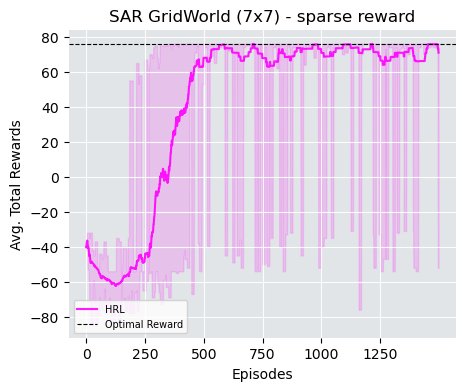

In [16]:
import matplotlib.pyplot as plt

def plot_learning_curve(total_rewards_list, EPISODES, labels, colors, optimal_reward):
    fig, ax = plt.subplots(figsize=(5, 4))
    for i, total_rewards in enumerate(total_rewards_list):
        mean_rewards_1, mean_rewards_50 = np.zeros(EPISODES), np.zeros(EPISODES)
        max_rewards, min_rewards = np.zeros(EPISODES), np.zeros(EPISODES)
        for t in range(EPISODES):
            mean_rewards_50[t] = np.mean(total_rewards[max(0, t-50):(t+1)])
            mean_rewards_1[t] = np.mean(total_rewards[max(0, t-50):(t+1)])
            max_rewards[t] = np.max(total_rewards[max(0, t-10):(t+1)])  # Adjust the range as needed
            min_rewards[t] = np.min(total_rewards[max(0, t-10):(t+1)])  # Adjust the range as needed
        ax.plot(mean_rewards_50, label=f'{labels[i]}', alpha=0.9, color=colors[i])
        ax.fill_between(range(EPISODES), min_rewards, max_rewards, color=colors[i], alpha=0.15)

    ax.axhline(y=optimal_reward, color='black', linestyle='--', label='Optimal Reward', linewidth=0.8)
    ax.legend(fontsize=7, loc='best')
    ax.grid(True, color="white", linestyle='-', alpha=0.9)
    faint_lavender = mcolors.to_rgba('slategrey', alpha=0.2)
    ax.set_facecolor(faint_lavender)
    plt.xlabel("Episodes")
    plt.xticks(np.arange(0, EPISODES, step=250))
    plt.ylabel("Avg. Total Rewards")
    plt.title("SAR GridWorld (7x7) - sparse reward")
    for spine in ax.spines.values():
        spine.set_visible(False)
    plt.show()

# Example usage
EPISODES = 1500
labels = ["HRL"]
colors = ["magenta"]
total_rewards_list = [avg_total_rewards_AGENT_hier]#, avg_total_rewards_AGENT_1_ATTENTION]
plot_learning_curve(total_rewards_list, EPISODES, labels, colors, optimal_reward=76)


In [ ]:
def evaluate(env, manager, workers, num_trials=1):
    for trial in range(num_trials):
        state = env.reset()
        done = False
        collisions = []
        total_reward, cnt, steps = 0, 0, 0
        print(f"Trial {trial + 1} starting:")
        
        while not done:
            # env.render()
            # Manager decides the option based on the current state
            option = env.current_option #= manager.choose_action(state, evaluation=True)
            # Select the appropriate worker
            if option == 0:
                worker = explore_worker
            elif option == 1:
                worker = collect_worker
            elif option == 2:
                worker = save_worker
            else:
                raise ValueError("Invalid option")
            
            # Worker takes the best known action
            action = worker.choose_action(state, evaluation=True)
            next_state, reward, done, _ = env.step(action)
            
            print(f"  State: {state}, Option: {option}, Action: {action}, Next State: {next_state}, Reward: {reward}")
            state = next_state
            total_reward += reward
            if tuple([state[0], state[1]]) in env.fires:
                cnt += 1
                collisions.append(tuple([state[0], state[1]]))
            steps += 1
        
        print(f"Trial {trial + 1} finished after {steps} with total reward: {total_reward} and {cnt} collisions at {collisions}")

# Evaluate the learned policy
evaluate(env, manager, {
    'explore': explore_worker,
    'collect': collect_worker,
    'save': save_worker
})


In [ ]:
env.fires

In [ ]:
def evaluate_policy(env, workers, num_episodes=1):
    total_rewards = 0  # To accumulate rewards across all episodes

    for episode in range(num_episodes):
        state = env.reset()
        done = False
        episode_reward = 0  # To accumulate rewards for the current episode

        while not done:
            current_option = env.current_option  # Get current option from the environment
            
            # Choose the best action from the current worker's Q-table
            worker = workers[current_option]
            action = worker.choose_action(state, evaluation=True)
            
            # Execute the action in the environment
            next_state, reward, done, _ = env.step(action)
            
            # Log the details of the current step
            print(f"Episode {episode + 1}, Step: State {state}, Option {current_option}, Action {action}, Reward {reward}, Next State {next_state}")
            
            # Update state and accumulate reward
            state = next_state
            episode_reward += reward
        
        print(f"Episode {episode + 1} finished with Total Reward: {episode_reward}")
        total_rewards += episode_reward

    average_reward = total_rewards / num_episodes
    print(f"Average Reward per Episode: {average_reward}")
    return average_reward
evaluate_policy(env, workers, num_episodes=1)

In [ ]:
import json
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.document_loaders import PyPDFLoader
from langchain_community.vectorstores import Chroma
from langchain_community import embeddings
from langchain_community.chat_models import ChatOllama
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain.output_parsers import PydanticOutputParser
from langchain.text_splitter import CharacterTextSplitter
from langchain_experimental.llms.ollama_functions import OllamaFunctions
from langchain_community.document_loaders import JSONLoader
from pprint import pprint
# from utils_functions import get_file_type

### class that processes verbal inputs handle disaster-related verbal inputs, analyze them using RAG architecture, and generate a 
# response in a specified format. It leverages models like ChatOllama and techniques like vector storage and retrieval for its operations.
class DisasterResponseAssistant:
    def __init__(self, data_path, data_type, model_name="mistral", embedding_model='nomic-embed-text', collection_name="rag-chroma"):
        self.model_name = model_name
        self.embedding_model = embedding_model
        self.collection_name = collection_name
        self.data_path = data_path
        self.data_type = data_type
        
        self.llm = None
        self.loader = None
        self.vectorstore = None
        self.retriever = None
        
        self._load_model()            # Initializes an instance of the ChatOllama model    
        self._load_documents()        # Loads and splits the PDF document into chunks
        self._create_vectorstore()    # Creates a vector store using Chroma from the document splits
        self._create_retriever()      # Creates a retriever from the vector store
        
        self.hazard_coordinates = []  # To store hazard coordinates
        self.poi_coordinates = []     # To store points of interest coordinates
    
    def _load_model(self):
        self.llm = ChatOllama(model=self.model_name)
        

    def _load_documents(self): ## for json documents
        print(f"document {self.data_type} will be infused")
        if self.data_type == 'pdf':
            self.loader = PyPDFLoader(self.data_path)
            self.data = self.loader.load_and_split()
        elif self.data_type == 'json':
            self.loader = JSONLoader(
                file_path=self.data_path,
                jq_schema='.',
                text_content=False)
            self.data = self.loader.load()
            #pprint(self.data)
        else:
            raise ValueError("Unsupported document type. Please choose either 'pdf' or 'json'.")


    def _create_vectorstore(self): ## for json documents
        self.vectorstore = Chroma.from_documents(
            documents=self.data,
            collection_name=self.collection_name,
            embedding=embeddings.OllamaEmbeddings(model=self.embedding_model),
        )

        
    def _create_retriever(self):
        self.retriever = self.vectorstore.as_retriever()

    ### generate a response based on a verbal input
    ### construct a template for the response using RAG architecture
    def generate_response(self, verbal_input):
        prompt_template = """You are an assistant, who carefully listens to verbal inputs: {verbal_input} and specialized in analyzing disaster-related inputs. Your task is 
to identify physical locations mentioned in the text and classify them as either points of interest (POI) or as hazards/dangers (HAZARD) for rescue operations. Use the
information provided in the documents: {context}, such as KEYWORDS, descriptions and context when locations are mentioned, to make your classification.
Output the classification in the form of a JSON array dictionary with keys 'location', 'coordinates', and 'category'. Here are some rules you always follow:
- Focus strictly on physical locations. Avoid including entities that do not represent physical, geographical places (such as individuals, conditions, or 
  abstract concepts).
- Generate human-readable output in the specified dictionary format.
- Generate only the requested output, strictly following the dictionary structure.
- Within the dictionary, the value of the `category` key must be either 'POI' or 'HAZARD'. 
- Never generate offensive or foul language.
- Never give explanations over your output.
Input: {verbal_input}
"""
        system_template = ChatPromptTemplate.from_template(prompt_template)
        output_parser = StrOutputParser()
        after_rag_chain = (
            {"context": self.retriever, "verbal_input": RunnablePassthrough()}
            | system_template
            | self.llm  # Assuming model_local is defined elsewhere and accessible
            | output_parser
        )
        response = after_rag_chain.invoke(verbal_input)
        return response
    
    def refine_response(self, output):
        cleaned_output_str = output.strip().replace('\n', '').replace('(', '[').replace(')', ']')
        output_dict = json.loads(cleaned_output_str)

        for item in output_dict:
            coord = tuple(item['coordinates'])
            if item['category'] == 'HAZARD':
                self.hazard_coordinates.append(coord)
            else:
                self.poi_coordinates.append(coord)
                    
        print("Hazardous Coordinates:", self.hazard_coordinates)
        print("Point of Interest Coordinates:", self.poi_coordinates)
        return self.hazard_coordinates, self.poi_coordinates

In [ ]:
class SARenvHRL:
    def __init__(self, gridsize, startState, finalState, ditches, fires, POIs, infoLocation, image_path, document_path, mode='prod'):
        self.gridsize = gridsize
        self.startState = startState
        self.finalState = finalState
        self.ditches = ditches
        self.infoLocation = infoLocation
        self.fires = fires
        self.POIs = POIs
        
        self.maxSteps = 2 * (self.gridsize[0] * self.gridsize[1])  # max steps needed for NAVIGATION -- EXPLORE
        self.ditchPenalty = -20
        self.turnPenalty = -1
        self.savePenalty = -10
        self.exceedStepPenalty = -1
        self.wrongCollectPenalty = -4
        self.askingReward = 10  ##4
        self.winReward = 100   ## 108
    
        self.mode = mode
        
        self.desired_cell_size = 50  # The size of cells in the grid for visualization
        self.generate_annotated_image(image_path)
        
        self.actionspace = {'EXPLORE': ['up', 'down', 'left', 'right'], 
                     'COLLECT': ['get X', 'get Y', 'get Z', 'get A', 'get B', 'get C'],
                     'SAVE': ['save', 'use', 'remove', 'carry']}
        self.optionspace = ['EXPLORE', 'COLLECT', 'SAVE']

        
        self.visited_information_state = False
        self.isGameEnd = False
        self.info_collectedX = False
        self.info_collectedY = False
        self.info_collectedZ = False
        self.option = self.optionspace[0]
        self.totalTurns = 0
        self.totalAsks = 0
        self.totalSaves = 0
        self.victim_saved = False
        self.correct_sequence = ['X', 'Y']
        
        self.collected_info = []
        self.ask_action_counter = 0
        
        # self.document_type = self.get_file_type(document_path)
        # self.assistant = DisasterResponseAssistant(document_path, self.document_type)
        self.ask_action_counter = 0
        self.hazards = []
        self.pois = []
        self.sensor_readings = {}
        
    
        self.current_state = (self.startState[0], self.info_collectedX, self.info_collectedY, self.info_collectedZ, self.victim_saved)
        if self.mode == 'debug':
            print("Initialization complete.")
        
        
        self.keywords_for_POIs = ["victim", "trail", "potential sighting", "Screams", "shelter", "high ground", "water source",
                                  "access route", "last known position", "high probability area", "safe"]
        self.keywords_for_danger = ["fire", "heat", "smoke", "restricted", "no access allowed", "flames", "dangerous", "steep terrain",
                                    "dense vegetation", "unstable structures", "unstable buildings", "hazardous material", "unsafe"]

        self.locationsDict = {
            'hospital': (5, 0),
            'train station': (5, 7), ## (6, 5)
            'school': (3, 0),
            'mall': (5, 2),  # (1, 1)
            'bank': (10, 0),
            'restaurant': (8, 6),
            'shop': (6, 5)
        }
    
    def reset(self):
        self.already_asked_for_X = False
        self.already_asked_for_Y = False
        self.correct_sequence = ['X', 'Y']
        self.visited_information_state = False
        self.collected_info = []
        self.info_collectedX, self.info_collectedY, self.info_collectedZ = False, False, False
        self.victim_saved = False
        self.isGameEnd = False
        self.totalTurns = 0
        self.totalAsks = 0
        self.totalSaves = 0
        self.position = self.startState[0]
        self.option = self.optionspace[0]
        self.current_state = (self.position, self.info_collectedX, self.info_collectedY, self.info_collectedZ, self.victim_saved)
        return self.current_state
    
    def get_file_type(self, docs_path):
        # Split the path and get the extension
        _, file_extension = os.path.splitext(docs_path)
        # Return the file extension without the period
        return file_extension[1:] if file_extension else None

    ##### ----------------------------
    
    def next_state_vision(self, target_state, action):  ### here just movement, thus just EXPLORE option
        position = target_state
        next_position = position
        # Movement actions update
        if action == self.actionspace[self.optionspace[0]][0] and position[0] > 0:  # up
            next_position = (position[0] - 1, position[1])
        elif action == self.actionspace[self.optionspace[0]][1] and position[0] < self.gridsize[0] - 1:  # down
            next_position = (position[0] + 1, position[1])
        elif action == self.actionspace[self.optionspace[0]][2] and position[1] > 0:  # left
            next_position = (position[0], position[1] - 1)
        elif action == self.actionspace[self.optionspace[0]][3] and position[1] < self.gridsize[1] - 1:  # right
            next_position = (position[0], position[1] + 1)
        return (next_position)
    
    
    def ask_action(self, state):
        self.ask_action_counter += 1
        position, info_collectedX, info_collectedY, info_collectedZ, victim_saved = state
        verbal_inputs = []
        if not info_collectedY:
            
            # VERBAL_INPUT1 = "Hey, there's a victim at the hospital."
            # VERBAL_INPUT2 = "Watch out, fire was reported next to the mall."#. There's a shelter through the bank and the train station."
            # #VERBAL_INPUT3 = "Someone told me about Screams heard at the shop and close to restaurant."
            # verbal_inputs.append(VERBAL_INPUT1)
            # verbal_inputs.append(VERBAL_INPUT2)
            # #verbal_inputs.append(VERBAL_INPUT3)
            
            VERBAL_INPUT1 = "Hey, there's a victim at the hospital."
            VERBAL_INPUT2 = "Also, fire was reported at the train station."
            VERBAL_INPUT3 = "There is a fire at the bank."
            VERBAL_INPUT4 = "A safe area is the mall."
            VERBAL_INPUT5 = "Keep an eye on the access route in the school."
            VERBAL_INPUT6 = "Keep an eye on the access route in the restaurant."
            VERBAL_INPUT7 = "Keep an eye on the access route in the shop."
            verbal_inputs.append(VERBAL_INPUT1)
            verbal_inputs.append(VERBAL_INPUT2)
            verbal_inputs.append(VERBAL_INPUT3)
            verbal_inputs.append(VERBAL_INPUT4)
            verbal_inputs.append(VERBAL_INPUT5)
            verbal_inputs.append(VERBAL_INPUT6)
            verbal_inputs.append(VERBAL_INPUT7)
            for input_text in verbal_inputs:
                    self.simulate_LLM_process_alternative(input_text)
    
    
    
            
            
    #         VERBAL_INPUT1 = "Hey, there's a victim at the hospital and I think I also saw fire in the train station and the bank. Hey, you wait! Someone told me about screams heard at the school and close to the mall. Hurry!"
    #         # VERBAL_INPUT1 = "Hey, there's a victim at the hospital and I think I also saw fire in the train station." #and the bank. Hey, you wait! Someone told me about screams heard at the school and close to the mall. Hurry!"
    #         verbal_inputs.append(VERBAL_INPUT1)
    #         if self.ask_action_counter <= 1:
    #             print(f"real LLM is about to start handling the input {VERBAL_INPUT1}")
    #             for input_text in verbal_inputs:
    #                 response = self.assistant.generate_response(input_text)
    #                 if response:
    #                     self.visited_information_state = True
    #                 self.hazards, self.pois = self.assistant.refine_response(response)
    #                 print(f"real LLM is about to end handling the input {VERBAL_INPUT1}")
    #                 self.update_environment_REAL(self.hazards, self.pois)
    #         else:
    #             #print(f"input will be handled hereby by pseudoLLM")
    #             #print(self.hazards, self.pois)
    #             self.visited_information_state = True
    #             self.update_environment_REAL(self.hazards, self.pois)
    #             # for input_text in verbal_inputs:
    #             #     self.simulate_LLM_process_alternative(input_text)
    
    # def update_environment_REAL(self, haz, poi):
    #     for hazardous_location in haz:
    #         self.sensor_readings[(hazardous_location, True, False, False, False)] = -10.0
    #         #self.sensor_readings[(hazardous_location, True)] = -10.0
    #         self.fires.append(hazardous_location)
    #     for safe_location in poi:
    #         self.sensor_readings[(safe_location, True, False, False, False)] = 10.0
    #         #self.sensor_readings[(safe_location, True)] = 10.0
    #         self.POIs.append(safe_location)
        
    
    ### Simulates the process of obtaining information from a language model (multiple locations)
    ### problem when two locations associated to different class are present in the smae sentence 
    def simulate_LLM_process_alternative(self, input):
        sum_embedding = torch.tensor([0, 0], dtype=torch.float32)
        locations_in_input = []
        for location in self.locationsDict:
            # Check if the location keyword is in the information string
            if location in input:
                location_embedding = torch.tensor(self.locationsDict[location], dtype=torch.float32)
                sum_embedding += location_embedding
                locations_in_input.append(tuple(int(x) for x in location_embedding.tolist()))
        #return locations_in_input
        if locations_in_input:
            #print(f"response is {locations_in_input} -- when input is: {input}")
            self.visited_information_state = True
            #print(f"response is {response}")
            sentences = input.split(". ") if ". " in input else [input]
            #print(f"the sentences are: {sentences}")
            for sentence in sentences:
                is_poi = any(keyword in sentence for keyword in self.keywords_for_POIs)
                is_fire = any(keyword in sentence for keyword in self.keywords_for_danger)
                #print(f"In sentence '{sentence}' we have POI: {is_poi} and fire: {is_fire}")
                for location, location_coords in self.locationsDict.items():
                    if location in sentence:
                        info = tuple(int(x) for x in torch.tensor(location_coords, dtype=torch.float32).tolist())
                        #print(f"info now is {info} and poi {is_poi} and fire {is_fire}")
                        # If the location is already categorized, skip it
                        if info in self.POIs or info in self.fires:
                            continue
                        # Add location to POIs or fires based on the context of the sentence
                        self.update_environment(info, is_poi, is_fire)
    
    def update_environment(self, info, is_poi, is_fire):
        if is_poi and not is_fire:
            self.sensor_readings[(info, True, True, False, False)] = 10.0
            self.POIs.append(info)
        elif is_fire and not is_poi:
            self.sensor_readings[(info, True, True, False, False)] = -10.0
            self.fires.append(info)                   
    
    ##### does not take into account the order of the info collection (WORKS)
    def step(self, action, option):
        position, info_collectedX, info_collectedY, info_collectedZ, victim_saved = self.current_state  # Unpack the current state        
        option_terminated = False
        fell_into_ditch = False
        next_position = position
        
    
        if option == self.optionspace[0]:  ### EXPLORE
            if action in self.actionspace[self.optionspace[0]]:   ### ['up', 'down', 'left', 'right']
                self.totalTurns += 1
                # Movement actions update
                if action == self.actionspace[self.optionspace[0]][0] and position[0] > 0:  # up
                    next_position = (position[0] - 1, position[1])
                elif action == self.actionspace[self.optionspace[0]][1] and position[0] < self.gridsize[0] - 1:  # down
                    next_position = (position[0] + 1, position[1])
                elif action == self.actionspace[self.optionspace[0]][2] and position[1] > 0:  # left
                    next_position = (position[0], position[1] - 1)
                elif action == self.actionspace[self.optionspace[0]][3] and position[1] < self.gridsize[1] - 1:  # right
                    next_position = (position[0], position[1] + 1)
            # Check if information is collected or if the agent fell into a ditch
            if (next_position == self.infoLocation[0] and not info_collectedX) or \
                (next_position == self.infoLocation[1] and not info_collectedY and info_collectedX) or \
                (next_position == self.infoLocation[2] and not info_collectedZ and info_collectedX and info_collectedY):
                    option_terminated = True
                    
            
            if next_position == self.finalState[0] and info_collectedX and info_collectedY and not victim_saved:
                option_terminated = True
                
            
            if self.totalTurns > self.maxSteps or next_position in self.ditches:
                option_terminated = True
                fell_into_ditch = next_position in self.ditches  # Agent fell into a ditch if true
                

        
        elif option == self.optionspace[1]:  ### COLLECT
            # Ask actions update
            if action in self.actionspace[self.optionspace[1]]:  ### ['get X', 'get Y', 'get Z']
                # Ask actions update
                self.totalAsks += 1
                info_type = action.split(' ')[1]  # Extract the type of information being collected ('X', 'Y', 'Z')
                if position == self.infoLocation[0] and info_type == 'X':
                    # self.ask_action(self.current_state)
                    info_collectedX = True
                    self.collected_info.append(info_type)
                    option_terminated = True
                elif position == self.infoLocation[1] and info_type == 'Y':
                    self.ask_action(self.current_state)
                    info_collectedY = True
                    self.collected_info.append(info_type)
                    option_terminated = True
                elif position == self.infoLocation[2] and info_type == 'Z':
                    info_collectedZ = True
                    self.collected_info.append(info_type)
                    option_terminated = True
                else:
                    # If the agent is not at the correct location or the info is out of sequence,
                    # the option is terminated.
                    option_terminated = True
                    
        elif option == self.optionspace[2]:   ### SAVE 
            if action in self.actionspace[self.optionspace[2]]: ### ['save']
                if action == 'save' and position == self.finalState[0] and info_collectedX and info_collectedY:
                    # Assuming saving is only contingent on collecting information X for simplicity
                    victim_saved = True
                    option_terminated = True
                else:
                    #reward = self.wrongCollectPenalty  # Or another penalty as appropriate
                    option_terminated = True
        
        
        # Check if all information has been collected in the correct sequence
        all_info_collected_in_correct_order = self.collected_info == self.correct_sequence
        #done = next_position == self.finalState[0] and all_info_collected_in_correct_order
        done = next_position == self.finalState[0] and victim_saved and all_info_collected_in_correct_order
        reward = self.calculate_reward(position, action, next_position, done, option, fell_into_ditch, info_collectedX, info_collectedY, info_collectedZ, victim_saved)
        ditch_event = fell_into_ditch  # Set ditch_event based on whether the agent fell into a ditch
        # Reset the agent's position to the start state if it fell into a ditch
        if fell_into_ditch:
            next_position = self.startState[0]  ## an xtupisw empodio to option kanei terminate alla oxi to epeisodio
        
        self.current_state = (next_position, info_collectedX, info_collectedY, info_collectedZ, victim_saved)
        return self.current_state, reward, done, option_terminated, ditch_event
    

    def calculate_reward(self, position, action, next_position, done, option, fell_into_ditch, info_collectedX, info_collectedY, info_collectedZ, victim_saved):
        reward = 0  # Base reward
        # Penalize for moving, encouraging efficient pathfinding
        reward += self.turnPenalty
        # Penalize for falling into a ditch
        if fell_into_ditch:
            reward += self.ditchPenalty
            return reward  # Early return since the episode restarts after falling into a ditch
        # Reward for collecting information in correct sequence
        if option == 'COLLECT':
            if info_collectedX and self.is_sequence_correct() and not self.already_asked_for_X:
                reward += self.askingReward  # Reward for collecting X
                self.already_asked_for_X = True
            # elif next_position == self.infoLocation[0] and info_collectedX:
            #     reward += self.wrongCollectPenalty
            # --------
            if info_collectedY and self.is_sequence_correct() and not self.already_asked_for_Y:
                reward += self.askingReward  # Reward for collecting Y in sequence after X
                self.already_asked_for_Y = True
            # --------

            # if self.already_asked_for_X or se
        
        # elif next_position == self.infoLocation[1] and info_collectedY:
        #     reward += self.wrongCollectPenalty  # Penalize for collecting out of order or at the wrong location
        # Reward for completing the episode successfully
        if done:
            reward += self.winReward  # Big reward for saving the victim after collecting all required info

        return reward


    # ## this calculate reward function works with the deterministically select option method in the agents' classes
    # def calculate_reward(self, position, action, next_position, done, current_option, fell_into_ditch, info_collectedX, info_collectedY, info_collectedZ, victim_saved):
    #     if fell_into_ditch:
    #         return self.ditchPenalty
    #     elif done:
    #         return self.winReward
    #     elif self.totalTurns > self.maxSteps:
    #         return self.exceedStepPenalty
    #     elif current_option == self.optionspace[1] and not self.is_sequence_correct():
    #         return self.wrongCollectPenalty  # Assume you have defined this penalty value in the initializer
        

    #     # elif current_option == self.optionspace[1]:
    #     #     if (position == self.infoLocation[0] and info_collectedX):
    #     #         return self.askingReward  # Reward for correctly collecting X at location 0
    #     #     elif (position == self.infoLocation[1] and info_collectedY):
    #     #         return self.askingReward  # Reward for correctly collecting Y at location 1
    #     #     else:
    #     #         return self.wrongCollectPenalty

    #     else:
    #         return self.turnPenalty
    
    def is_sequence_correct(self):
        return self.collected_info == self.correct_sequence[:len(self.collected_info)]

    
    # def calculate_discrepancy(self, collected_info):
    #     # Initialize the discrepancy score
    #     discrepancy_score = 0
    #     # Create a mapping of element to its index in the optimal_sequence for order comparison
    #     optimal_indexes = {element: index for index, element in enumerate(list(self.ListB.keys()))}
    #     # Check for missing elements and add their weights to the discrepancy score
    #     for element in list(self.ListB.keys()):
    #         if element not in collected_info:
    #             discrepancy_score += self.ListB[element]
    #     # Check the order for elements in the estimated_sequence
    #     last_index = -1  # Initialize with an index that's before the first element's index
    #     for element in collected_info:
    #         if element in optimal_indexes:
    #             current_index = optimal_indexes[element]
    #             # If the current element is out of order, add its weight to the discrepancy score
    #             if current_index < last_index:
    #                 discrepancy_score += self.ListB[element]
    #             else:
    #                 # Update last_index to the current element's index if it's in correct order
    #                 last_index = current_index
    #     #print(discrepancy_score)
    #     return discrepancy_score
    
    

    ### Methods for annotating and generating images of the environment grid
    def annotate_cell(self, ax, row, col, text, color='white'):
        """ Annotates a specific cell in the grid with given text and color. """
        ax.text(col * self.desired_cell_size + self.desired_cell_size/2,
                row * self.desired_cell_size + self.desired_cell_size/2,
                text,
                ha='center',
                va='center',
                color=color,
                fontsize=15,
                weight='bold')
    
    
    def generate_annotated_image(self, image_path):
        # Load and process the image
        img = Image.open(image_path)
        # Resize and crop image to fit the grid
        aspect_ratio = img.width / img.height
        if aspect_ratio > 1:
            new_size = (self.gridsize[0] * img.height // self.gridsize[1], img.height)
        else:
            new_size = (img.width, self.gridsize[1] * img.width // self.gridsize[0])
        img = img.resize(new_size, Image.Resampling.LANCZOS)
        crop_x = (img.width - self.gridsize[0] * (img.height // self.gridsize[1])) // 2
        crop_y = (img.height - self.gridsize[1] * (img.width // self.gridsize[0])) // 2
        img = img.crop((crop_x, crop_y, img.width - crop_x, img.height - crop_y))
        # Resize image to have equal cells
        new_image_width = self.desired_cell_size * self.gridsize[0]
        new_image_height = self.desired_cell_size * self.gridsize[1]
        img = img.resize((new_image_width, new_image_height))
        # Create figure with annotations
        if not self.gridsize == [17, 17]:
            fig, ax = plt.subplots(figsize=(8, 8))
        else:
            fig, ax = plt.subplots(figsize=(15, 15))
        ax.imshow(img)
        # Draw grid lines in white
        ax.set_xticks([i * self.desired_cell_size for i in range(self.gridsize[0] + 1)], minor=False)
        ax.set_yticks([i * self.desired_cell_size for i in range(self.gridsize[1] + 1)], minor=False)
        ax.grid(which="both", color="white", linestyle='-', linewidth=2)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        # Add annotations for each cell
        for row in range(self.gridsize[1]):
            for col in range(self.gridsize[0]):
                cell_coord = (row, col)
                # Check for special states and annotate accordingly
                if cell_coord in self.startState:
                    self.annotate_cell(ax, row, col, 'START', color='coral')  # Start
                elif cell_coord in self.finalState:
                    self.annotate_cell(ax, row, col, 'VIC', color='cyan')  # Terminal
                elif cell_coord in self.ditches:
                    self.annotate_cell(ax, row, col, 'D', color='red')  # Ditch
                elif cell_coord in self.fires:
                    self.annotate_cell(ax, row, col, 'F', color='orange')  # Fire
                elif cell_coord in self.POIs:
                    self.annotate_cell(ax, row, col, 'P', color='purple')  # POI
                elif cell_coord in self.infoLocation:
                    self.annotate_cell(ax, row, col, 'INFO', color='yellow')  # Info
                else:
                    self.annotate_cell(ax, row, col, str(cell_coord))  # Regular cell coordinate
        # Save figure to buffer and load as PIL image
        buf = BytesIO()
        plt.savefig(buf, format='png')
        buf.seek(0)
        self.annotated_image = Image.open(buf)
    
    ### Visualizes the current state of the environment.
    ### Visualizes the current state of the environment.
    def render(self):
        clear_output(wait=True)
        fig, ax = plt.subplots(figsize=(8, 8))#plt.subplots()
        ax.set_xlim(0, self.gridsize[0])
        ax.set_ylim(0, self.gridsize[1])
        ax.set_xticks(range(self.gridsize[0]))
        ax.set_yticks(range(self.gridsize[1]))
        ax.grid(which='both')
        # Plotting the agent
        #agent_pos, _, _ = self.currentState
        agent_pos = self.position
        ax.plot(agent_pos[1] + 0.5, agent_pos[0] + 0.5, 'o', color='blue', markersize=10)  # Agent as a blue dot
        # Plotting the ditches
        for ditch in self.ditches:
            ax.plot(ditch[1] + 0.5, ditch[0] + 0.5, 'x', color='red', markersize=10)
        # Plotting the terminal state (victim's location)
        for terminal in self.finalState:
            ax.plot(terminal[1] + 0.5, terminal[0] + 0.5, 'P', color='green', markersize=10)
        for poi in self.POIs:
            ax.plot(poi[1] + 0.5, poi[0] + 0.5, 'P', color='pink', markersize=10)
        for hazard in self.fires:
            ax.plot(hazard[1] + 0.5, hazard[0] + 0.5, 'x', color='orange', markersize=10)
        # Plotting the info location
        for info in self.infoLocation:
            ax.plot(info[1] + 0.5, info[0] + 0.5, '*', color='yellow', markersize=10)
        plt.gca().invert_yaxis()
        plt.show()


In [ ]:
# Example initialization and training
gridsize = [17, 17] #[14, 14]
startState = [(0, 16)]
victimStates = [(5, 0)]
ditches = [(2, 7), (3, 7), (4, 7), (6, 7), (7, 7), (9, 7), (11, 7), (2, 11), (3, 11), (4, 11), (7, 15), (6 ,16), (7, 16), (8, 4), (7, 4),
           (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (13, 11), (12, 11), (12, 13), (13, 13), (13, 1), (13 ,2), (14, 1), (15, 1), (4, 3),
           (13, 7), (14, 8), (14, 9)]
fires = []
POIs = []  # Victim locations
infoLocation = [(10, 15), (7, 10), (16, 0)]  # Location to ask for information
image_path = "/Users/dimipan/Documents/HRL-LLM/images/Cyclone_Seroj.jpg"
document_path = '/Users/dimipan/Documents/HRL-LLM/data/sar_data_COMPLEX.json'

env = SARenvHRL(gridsize, startState, victimStates, ditches, fires, POIs, infoLocation, image_path, document_path, mode='debug')

In [ ]:
# Example initialization and training
gridsize = [7, 7]
startState = [(3, 0)]
victimStates = [(0, 3)]
ditches = [(1, 6), (2, 1), (2, 2), (2, 4), (3, 2), (3, 3), (3, 4), (4, 5),
         (5, 0), (5, 1), (5, 2), (6, 0), (0, 2), (0, 4), (5, 5)]

#ditches = []
fires = []
POIs = []  # Victim locations
#infoLocation = [(6, 1), (4, 4), (2, 6)]  # Location to ask for information was (6, 1)
#infoLocation = {(6, 1): 'X', (4, 4): 'Y', (2, 6): 'Z'}
infoLocation = [(4, 4), (4, 1), (2, 6)]
fires = []
POIs = []

image_path = "/Users/dimipan/Documents/HRL-LLM/images/disaster_area.jpg"
document_path = "/Users/dimipan/Documents/HRL-LLM/data/sar_data.json"
# image_path = "/home/dimiubuntu/Desktop/local_code_scripts/enhanced_RL/enhanced_RL/images/disaster_area.jpg"
# document_path = "/home/dimiubuntu/Desktop/local_code_scripts/enhanced_RL/enhanced_RL/data/sar_data.json"


env = SARenvHRL(gridsize, startState, victimStates, ditches, fires, POIs, infoLocation, image_path, document_path, mode='debug')

In [ ]:
class HierarchicalQLearningAgent:
    def __init__(self, environment, actions, alpha, gamma):
        self.actions = actions
        self.env = environment
        self.alpha = alpha
        self.gamma = gamma
        self.high_level_q_table = {}  # Maps state -> option -> Q-value
        self.low_level_q_table = {}  # Maps (state, option, action) -> Q-value
        
    def _get_high_q_value(self, state, option):
        return self.high_level_q_table.get((state, option), 0)

    def _get_low_q_value(self, state, action):
        return self.low_level_q_table.get((state, action), 0)


    # def select_option(self, state, exploration_rate):
    #     position, info1, info2, info_3, victim = state
    #     if not info1:
    #         if position == self.env.infoLocation[0]:
    #             return 'COLLECT'
    #         else:
    #             return 'EXPLORE'
    #     elif not info2 and info1:
    #         if position == self.env.infoLocation[1]:
    #             return 'COLLECT'
    #         else:
    #             return 'EXPLORE'
    #     elif info1 and info2 and not victim:
    #         if position == self.env.finalState[0]:
    #             return 'SAVE'
    #         else:
    #             return 'EXPLORE'
    #     # else:
    #     #     return 'EXPLORE'
        
        
    def select_option(self, state, exploration_rate):
        if random.random() < exploration_rate:
            return random.choice(list(self.actions.keys()))
        else:
            q_values = {option: self._get_high_q_value(state, option) for option in self.actions.keys()}
            return max(q_values, key=q_values.get)

    def select_action(self, state, option, exploration_rate):
        if random.random() < exploration_rate:
            return random.choice(self.actions[option])
        else:
            q_values = {(state, option, action): self._get_low_q_value((state, option), action) for action in self.actions[option]}
            return max(q_values, key=q_values.get)[2]

    def update(self, state, option, action, reward, next_state, done):
        # Update low-level Q-value
        current_q = self._get_low_q_value((state, option), action)
        next_max_q = max(self._get_low_q_value((next_state, option), a) for a in self.actions[option]) if not done else 0
        self.low_level_q_table[((state, option), action)] = current_q + self.alpha * (reward + self.gamma * next_max_q - current_q)

        # Update high-level Q-value
        current_option_q = self._get_high_q_value(state, option)
        next_max_option_q = max(self._get_high_q_value(next_state, o) for o in self.actions.keys()) if not done else 0
        self.high_level_q_table[(state, option)] = current_option_q + self.alpha * (reward + self.gamma * next_max_option_q - current_option_q)

    def execute_option(self, initial_state, option, exploration_rate, visit_counts):
        state = initial_state
        total_reward = 0
        done = False
        option_terminated = False ##
        self.env.totalTurns = 0
        self.env.totalAsks = 0
        self.env.totalSaves = 0
        
        while not done:
            action = self.select_action(state, option, exploration_rate)
            next_state, reward, done, option_terminated, ditch_event = self.env.step(action, option)
            if ditch_event:
                # Apply the penalty for the ditch event but reset the state for the next iteration
                self.update(state, option, action, reward, next_state, done)
                #print(f"O: {option} | {state} | a: {action} | s_: {next_state} | r: {reward}")
                state = self.env.reset()  # Reset to start state after applying penalty
            else:
                # Regular update when no ditch event
                self.update(state, option, action, reward, next_state, done)
                #print(f"O: {option} | {state} | a: {action} | s_: {next_state} | r: {reward}")
                state = next_state
            
            total_reward += reward
            if state[0] in visit_counts:
                visit_counts[state[0]] += 1
            else:
                visit_counts[state[0]] = 1
                
            
            if option_terminated or done:
                break
        
        return state, total_reward, done, visit_counts
    
    
    # Training Loop
    def train_agent(self, episodes):
        exploration_rate = 1.0
        min_exploration_rate = 0.01
        exploration_decay = 2
        rewards = []
        total_reward, Rewards, mean_reward = 0, 0, 0
        total = np.zeros(episodes)
        max_epochs_per_option = 20
        option_epoch = 0
        visit_counts = {}

        for episode in tqdm(range(episodes)):
            if episode % 250 == 0:
                print(f"Episode: {episode}, Total Reward: {total_reward}, Exploration Rate: {exploration_rate}")
            state = self.env.reset()
            total_reward = 0
            Rewards = 0
            mean_reward = 0
            done = False
            option_terminated = False
            option_epoch = 0

            while not done and option_epoch < max_epochs_per_option:
            
                option = self.select_option(state, exploration_rate)
                #print(f"\n----- option selected: {option} at episode: {episode} | ep_step: {option_epoch}")
                state, reward, done, visit_counts = self.execute_option(state, option, exploration_rate, visit_counts)
                total_reward += reward
                Rewards += reward
                option_epoch += 1

            # Decay exploration rate
            #exploration_rate = max(min_exploration_rate, exploration_rate * exploration_decay)
            
            if exploration_rate > 0.1:
                exploration_rate -= exploration_decay/episodes
            else:
                exploration_rate = min_exploration_rate
            
            rewards.append(total_reward)  ## total_reward
            total[episode] = Rewards  ## Rewards

        return rewards, total, visit_counts

In [ ]:
class HierarchicalQLearningAgent_ATTENTION:
    def __init__(self, environment, actions, alpha, gamma, image_path):
        self.actions = actions
        self.env = environment
        self.alpha = alpha
        self.gamma = gamma
        self.image_path = image_path
        self.high_level_q_table = {}  # Maps state -> option -> Q-value
        self.low_level_q_table = {}  # Maps (state, option, action) -> Q-value
        self.exploit_start_episode = None
        self.exploit_end_episode = None
        self.exploit_episodes = 500  # 30% of the episodes
        self.exploit_initiated = False
        self.exploit_mode = False
        
        self.attention_space_HIGH = {}
        self.attention_space_LOW = {}
    
    def identify_changes_states(self, readings):
        updated_locations = [updated_loc for updated_loc, sensor_value in readings.items() if readings]
        return updated_locations
            
    ### Finds states connected to a given target state, considering possible actions and their inverse
    def get_connected_states(self, target_state):
        ### {'up': 'down', 'down': 'up', 'left': 'right', 'right': 'left'} -- Inverse action mapping for movement actions
        inverse_actions = {env.actionspace[env.optionspace[0]][0]: env.actionspace[env.optionspace[0]][1],
                        env.actionspace[env.optionspace[0]][1]: env.actionspace[env.optionspace[0]][0],
                        env.actionspace[env.optionspace[0]][2]: env.actionspace[env.optionspace[0]][3],
                        env.actionspace[env.optionspace[0]][3]: env.actionspace[env.optionspace[0]][2]}
        connected_states_pairs = []   # Generate state-action pairs
        for action in self.actions[self.env.optionspace[0]]:   ## we just care about the navigation connections
            inverse_action = inverse_actions[action] # Apply the inverse action to the target state
            possible_prev_state = self.env.next_state_vision(target_state[0], inverse_action)
            #print(f"poss prev: {possible_prev_state}")
            # Check if the resulting state is valid and leads to the target state
            if possible_prev_state != target_state[0] and possible_prev_state not in self.env.ditches:
                connected_states_pairs.append((possible_prev_state, action))
        #print(f"out from get_connected: {connected_states_pairs}")
        return connected_states_pairs

    ### Updates the attention space, which influences the agent's decision-making based on environmental changes. ### more like policy-shaping
    def update_attention_space(self, connection, sensor_readings):
        connected_states = self.get_connected_states(connection)
        print(connected_states)
        # Determine the value to add based on sensor reading
        value_to_add = 10.0 if sensor_readings[connection] > 0 else -10.0
        for connected_state, action in connected_states:    # Update the attention space value for the state-action pair
            ## here we update the attention space low that directly affects the low-level Q table (low level action selection)
            self.attention_space_LOW[(((connected_state, True, True, False, False), self.env.optionspace[0]), action)] = value_to_add  ### (((connected_state), True, False, False), 'EXPLORE'), 'action'): value_to_add
            ## here we update the attention space high that directly affects the high-level Q table (high level action selection -- option selection)
            if value_to_add > 0: # For positive sensor readings, enhance the value for 'EXPLORE' option
                self.attention_space_HIGH[(((connected_state), True, True, False, False), self.env.optionspace[0])] = value_to_add ### (((connected_state), False, False, False), 'option'): value
            else: # For negative sensor readings, decrease the value for options other than 'EXPLORE'# For negative sensor readings, decrease the value for options other than 'EXPLORE'
                self.attention_space_HIGH[(((connected_state), True, True, False, False), self.env.optionspace[1])] = value_to_add
                self.attention_space_HIGH[(((connected_state), True, True, False, False), self.env.optionspace[2])] = value_to_add
        # Check if the new information refers to the victim state and update exclusively for SAVE option and 'save' action under SAVE option
        if connection[0] in self.env.finalState:
            victim_state_option_pair = (((connection[0], True, True, False, False), self.env.optionspace[2]))
            self.attention_space_HIGH[victim_state_option_pair] = 100

            victim_state_action_pair = (((connection[0], True, True, False, False), \
                                        self.env.optionspace[2], self.env.actionspace[self.env.optionspace[2]][0]))
            self.attention_space_LOW[victim_state_action_pair] = 100
            
            ## # Positive value adds to 'EXPLORE', negative to 'ASK' (and could be expanded to others)
            #self.attention_space_HIGH[((connected_state, True, False, False), 'EXPLORE' if value_to_add > 0 else 'ASK')] = value_to_add
        return self.attention_space_HIGH, self.attention_space_LOW


    def update_q_tables_from_attention(self):
        if self.attention_space_HIGH:
            for key, value in self.attention_space_HIGH.items():
                if key in self.high_level_q_table:
                    self.high_level_q_table[key] = self.high_level_q_table[key] + value
                else:
                    self.high_level_q_table[key] = value
                ###here it works
        if self.attention_space_LOW:
            for key, value in self.attention_space_LOW.items():
                if key in self.low_level_q_table:
                    self.low_level_q_table[key] = self.low_level_q_table[key] + value
                else:
                    self.low_level_q_table[key] = value
        
        
    def _get_high_q_value(self, state, option):
        return self.high_level_q_table.get((state, option), 0)

    def _get_low_q_value(self, state, action):
        return self.low_level_q_table.get((state, action), 0)
    

    # def select_option(self, state, exploration_rate):
    #     position, info1, info2, info_3, victim = state
    #     if not info1:
    #         if position == self.env.infoLocation[0]:
    #             return 'COLLECT'
    #         else:
    #             return 'EXPLORE'
    #     elif not info2 and info1:
    #         if position == self.env.infoLocation[1]:
    #             return 'COLLECT'
    #         else:
    #             return 'EXPLORE'
    #     elif info1 and info2 and not victim:
    #         if position == self.env.finalState[0]:
    #             return 'SAVE'
    #         else:
    #             return 'EXPLORE'

    def select_option(self, state, exploration_rate):
        if not self.env.visited_information_state:
            if random.random() < exploration_rate:
                return random.choice(list(self.actions.keys()))
            else:
                q_values = {option: self._get_high_q_value(state, option) for option in self.actions.keys()}
                return max(q_values, key=q_values.get)
        else:
            # if random.random() < 0.01:
            #     return random.choice(list(self.actions.keys()))
            # else:
                q_values = {option: self._get_high_q_value(state, option) for option in self.actions.keys()}
                return max(q_values, key=q_values.get)

    def select_action(self, state, option, exploration_rate):
        if not self.env.visited_information_state:
            if random.random() < exploration_rate:
                return random.choice(self.actions[option])
            else:
                q_values = {(state, option, action): self._get_low_q_value((state, option), action) for action in self.actions[option]}
                return max(q_values, key=q_values.get)[2]
        else:
            # if random.random() < 0.001:
            #     return random.choice(self.actions[option])
            # else:
                q_values = {(state, option, action): self._get_low_q_value((state, option), action) for action in self.actions[option]}
                return max(q_values, key=q_values.get)[2]

    def update(self, state, option, action, reward, next_state, done):
        # Update low-level Q-value
        current_q = self._get_low_q_value((state, option), action)
        next_max_q = max(self._get_low_q_value((next_state, option), a) for a in self.actions[option]) if not done else 0
        self.low_level_q_table[((state, option), action)] = current_q + self.alpha * (reward + self.gamma * next_max_q - current_q)

        # Update high-level Q-value
        current_option_q = self._get_high_q_value(state, option)
        next_max_option_q = max(self._get_high_q_value(next_state, o) for o in self.actions.keys()) if not done else 0
        self.high_level_q_table[(state, option)] = current_option_q + self.alpha * (reward + self.gamma * next_max_option_q - current_option_q)

    def execute_option(self, initial_state, option, exploration_rate, visit_counts):
        state = initial_state
        total_reward = 0
        done = False
        option_terminated = False ##
        self.env.totalTurns = 0
        self.env.totalAsks = 0
        self.env.totalSaves = 0
        
        while not done:
            action = self.select_action(state, option, exploration_rate)
            next_state, reward, done, option_terminated, ditch_event = self.env.step(action, option)
            if ditch_event:
                # Apply the penalty for the ditch event but reset the state for the next iteration
                self.update(state, option, action, reward, next_state, done)
                # print(f"O: {option} | {state} | a: {action} | s_: {next_state} | r: {reward}")
                state = self.env.reset()  # Reset to start state after applying penalty
            else:
                # Regular update when no ditch event
                self.update(state, option, action, reward, next_state, done)
                # print(f"O: {option} | {state} | a: {action} | s_: {next_state} | r: {reward}")
                state = next_state
            
            total_reward += reward
            if state[0] in visit_counts:
                visit_counts[state[0]] += 1
            else:
                visit_counts[state[0]] = 1
                
            
            if option_terminated or done:
                break

        return state, total_reward, done, visit_counts
    
    ### Manages the transition between exploration and exploitation modes based on information received
    def exploitation_strategy(self, received, current_episode):
        if received and not self.exploit_mode and not self.exploit_initiated:
            self.exploit_start_episode = current_episode
            self.exploit_end_episode = self.exploit_start_episode + self.exploit_episodes
            self.exploit_mode = True
            self.exploit_initiated = True
            print(f"Exploitation mode started at episode {self.exploit_start_episode}")
    
    
    # Training Loop
    def train_agent(self, episodes):
        exploration_rate = 1.0
        min_exploration_rate = 0.01
        exploration_decay = 2
        rewards = []
        total_reward, Rewards = 0, 0
        total = np.zeros(episodes)
        max_epochs_per_option = 20
        option_epoch = 0
        visit_counts = {}
        received_input = False
        attention_space_OPTIONS, attention_space_PRIMITIVES = {}, {}

        for episode in tqdm(range(episodes)):
            if episode % 250 == 0:
                print(f"Episode: {episode}, Total Reward: {total_reward}, Exploration Rate: {exploration_rate}")
            state = self.env.reset()
            total_reward = 0
            Rewards = 0
            done = False
            option_epoch = 0

            while not done and option_epoch < max_epochs_per_option:
                
                if self.env.visited_information_state and not received_input:
                    identified_states = self.identify_changes_states(self.env.sensor_readings)
                    received_input = True
                    self.env.generate_annotated_image(self.image_path) 
                    print(f"got the info needed at ep {episode} at location {state[0]}")
                    if identified_states:
                        for informed_state in identified_states:
                            attention_space_OPTIONS, attention_space_PRIMITIVES = self.update_attention_space(informed_state, self.env.sensor_readings)
                    self.update_q_tables_from_attention()
                            
                
                option = self.select_option(state, exploration_rate)
                #print(f"\n----- option selected: {option} at episode: {episode} | ep_step: {option_steps}")
                state, reward, done, visit_counts = self.execute_option(state, option, exploration_rate, visit_counts)
                total_reward += reward
                Rewards += reward
                option_epoch += 1

            # Decay exploration rate
            #exploration_rate = max(min_exploration_rate, exploration_rate * exploration_decay)
            if not self.env.visited_information_state:
                if exploration_rate > 0.1:
                        exploration_rate -= exploration_decay/episodes
                else:
                    exploration_rate = min_exploration_rate
            else:
                if exploration_rate > 0.1:
                    exploration_rate -= 8*exploration_decay/episodes
                else:
                    exploration_rate = min_exploration_rate
            
            # ### for now verbal input is considered truthful --- see (5b) for explanations
            # self.exploitation_strategy(received_input, episode)
            # if self.exploit_mode and self.exploit_start_episode <= episode < self.exploit_end_episode:
            #     if exploration_rate > 0.1:
            #         exploration_rate -= exploration_decay/episodes
            #     else:
            #         exploration_rate = min_exploration_rate
            #     if episode == self.exploit_end_episode - 1:
            #         self.exploit_mode = False
            #         print(f"Exploitation mode ends at episode {episode}")
            # else:
            #     if exploration_rate > 0.1:
            #         exploration_rate -= 4*exploration_decay/episodes
            #     else:
            #         exploration_rate = min_exploration_rate
            

            rewards.append(total_reward)
            total[episode] = Rewards
        # print(f"POIs identified during training {self.env.POIs}")
        # print(f"fires identified during training {self.env.fires}")

        return rewards, total, visit_counts, attention_space_OPTIONS, attention_space_PRIMITIVES

In [ ]:
ALPHA = 0.1
GAMMA = 0.998
EPISODES = 5000
agent_simple = HierarchicalQLearningAgent(env, env.actionspace, ALPHA, GAMMA)
rewards_Q, total_Q, visits_Q = agent_simple.train_agent(EPISODES)

In [ ]:
### agent's hyperparameters
ALPHA = 0.1
GAMMA = 0.998
EPISODES = 5000
agent_attention = HierarchicalQLearningAgent_ATTENTION(env, env.actionspace, ALPHA, GAMMA, image_path)
rewards_ATT, total_ATT, visits_ATT, att_optios_ATT, att_prim_ATT = agent_attention.train_agent(EPISODES)

In [ ]:
def plot_rewards(rewards1, rewards2, rewards3, rewards4):
    plt.figure(figsize=(20, 10))
    plt.plot(rewards1, label='Rewards per Episode')
    plt.plot(rewards2, label='Rewards per Episode')
    plt.plot(rewards3, label='Rewards per Episode')
    plt.plot(rewards4, label='Rewards per Episode')
    plt.xlabel('Episodes')
    plt.ylabel('Total Reward')
    plt.title('Total Rewards over Episodes')
    plt.legend()
    plt.show()

plot_rewards(rewards_Q, rewards_ATT, total_returns0, total_returns)

In [ ]:
def plot_learning_curve(total_rewards_list, EPISODES, labels, colors, optimal_reward):
    fig, ax = plt.subplots(figsize=(20, 10))
    for i, total_rewards in enumerate(total_rewards_list):
        mean_rewards_1, mean_rewards_50 = np.zeros(EPISODES), np.zeros(EPISODES)
        for t in range(EPISODES):
            mean_rewards_1[t] = np.mean(total_rewards[max(0, t-5):(t+1)])
            mean_rewards_50[t] = np.mean(total_rewards[max(0, t-150):(t+1)])
        ax.plot(mean_rewards_50, label=f'{labels[i]}', alpha=0.9, color=colors[i])
        ax.fill_between(range(EPISODES), mean_rewards_1, mean_rewards_50, color=colors[i], alpha=0.15)
        # Check for 20 consecutive iterations with reward >= optimal reward
        for t in range(EPISODES - 10):
            if all(total_rewards[t:t+10] >= optimal_reward):
                ax.axvline(x=t+10, color=colors[i], linestyle='dotted')
                print(f"Line appears at episode: {t+10} for agent {labels[i]}")
                break
    ax.axhline(y=optimal_reward, color='green', linestyle='--', label='Optimal Reward')
    ax.legend()
    ax.grid(True, alpha=0.4)  # Add this line to enable gridlines
    # ax.set_ylim([80, 110])  # Set y-axis limits
    plt.xlabel("Episodes")
    plt.xticks(np.arange(0, EPISODES, step=250))
    # plt.yscale('symlog')  # 'symlog' handles negative values as well as positive values

    plt.ylabel("Total Rewards")
    plt.title("Mean Total Rewards Comparison")
    plt.show()
labels = ["hierQ", "hierQ+", "Q", "Q+"]
colors = ["blue", "magenta", "orange", "red"]
total_rewards_list = [total_Q, total_ATT, total_returns0, total_returns]#, avg_total_rewards_AGENT_1_ATTENTION]
plot_learning_curve(total_rewards_list, EPISODES, labels, colors, optimal_reward=77)

In [ ]:
"""Initializes the SAR environment. It sets up the grid, start state, victim locations, hazards (ditches and fires),
points of interest (POIs), information location, and various rewards and penalties. It also prepares visualization tools.
"""

class SARenv:
    def __init__(self, gridsize, startState, victimStates, ditches, fires, POIs, infoLocation, image_path, mode='prod'):
        self.gridsize = gridsize              # size of the grid environment
        self.startState = startState          # The starting state of the agent
        self.victimStates = victimStates      # The locations where victims are present.
        self.ditches = ditches                # The locations representing obstacles (ditches) -- can't go through
        self.fires = fires                    # The locations representing fires.
        self.POIs = POIs                      #  Points of interest in the environment.
        self.infoLocation = infoLocation  # Location where the agent needs to ask for information
        self.maxSteps = 1 * (self.gridsize[0] * self.gridsize[1])  # Example step limit
        self.ditchPenalty = -30
        self.savePenalty = -5
        self.turnPenalty = -1
        self.askingReward = 6
        self.wrongAskPenalty = -5
        self.exceedStepPenalty = -5
        self.winReward = 100
        self.mode = mode
        
        # self.docs_path = "/home/research100/Documents/sample/enhanced_RL/enhanced_RL/data/rag_pseudo.pdf"
        #self.assistant = DisasterResponseAssistant(self.docs_path)
        self.ask_action_counter = 0
        self.hazards = []
        self.pois = []
        # Define the correct order of information collection
        self.referenceSequence = ['X', 'Y', 'Z']
        # Extend the initialization method to include the new info locations
        self.infoLocations = {
            (6, 1): 'X',
            (4, 4): 'Y',
            (2, 6): 'Z'
        }
        # Initialize a list to keep track of the types of information collected
        self.infoCollected = []



        self.desired_cell_size = 50  # The size of cells in the grid for visualization
        self.generate_annotated_image(image_path)

        self.create_statespace()
        self.create_statespace_VISUALISATION()
        self.stateCount = self.get_statespace_len()
        self.stateDict = {k: v for k, v in zip(self.statespace, range(self.stateCount))}
        self.currentState = (self.startState[0], False, False, False)  # State includes position and info statusX, and info statusY
        self.actionspace = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]  # Actions: 'UP', 'DOWN', 'LEFT', 'RIGHT', 'ASK', 'SAVE'
        self.actionDict = {0: 'UP', 1: 'DOWN', 2: 'LEFT', 3: 'RIGHT', 4: 'ASK', 5: 'SAVE', 6: 'ASK_Y', 7: 'ASK_Z', 
                           8: 'ASK_A', 9: 'ASK_B', 10: 'ASK_C', 11: 'use', 12: 'remove', 13: 'carry'}
        self.actionCount = self.get_actionspace_len()
        

        self.last_reward_state = None    # Attribute to remember the last reward state
        
        self.victim_saved = False
        self.isGameEnd = False
        self.visited_information_state = False
        self.response = None
        self.totalTurns = 0
        self.sensor_readings = {state: 1.0 for state in self.get_statespace()}

        self.keywords_for_POIs = ["victim", "trail", "potential sighting", "Screams", "shelter", "high ground", "water source",
                                  "access route", "last known position", "high probability area", "safe"]
        self.keywords_for_danger = ["fire", "heat", "smoke", "restricted", "no access allowed", "flames", "dangerous", "steep terrain",
                                    "dense vegetation", "unstable structures", "unstable buildings", "hazardous material", "unsafe"]

        self.locationsDict = {
            'hospital': (0, 3),
            'train station': (5, 6), ## (6, 5)
            'school': (3, 0),
            'mall': (4, 1),  # (1, 1)
            'bank': (6, 5),
            'restaurant': (2, 0),
            'shop': (1, 2),
            'bakery': (3, 6),
            'petrol station': (2, 5)
        }

        if self.mode == 'debug':
            print("State Space", self.statespace)
            print("State Dict", self.stateDict)
            print("Action Space", self.actionspace)
            print("Action Dict", self.actionDict)
            print("Start State", self.startState)
            print("Terminal States", self.victimStates)
            print("Ditches", self.ditches)
            print("WinReward:{}, TurnPenalty:{}, DitchPenalty:{}, savePenalty:{}, AskingReward:{}, \
                WrongAskPenalty:{}".format(self.winReward, self.turnPenalty, self.ditchPenalty, \
                    self.savePenalty, self.askingReward, self.wrongAskPenalty))

    def set_mode(self, mode):
        self.mode = mode
    def create_statespace(self):
        self.statespace = [((row, col), info_statusX, info_statusY, info_statusZ)
                           for row in range(self.gridsize[0])
                           for col in range(self.gridsize[1])
                           for info_statusX in [False, True]
                           for info_statusY in [False, True]
                           for info_statusZ in [False, True]]
    def get_statespace(self): return self.statespace
    def get_actionspace(self): return self.actionspace
    def get_statespace_len(self): return len(self.statespace)
    def get_actionspace_len(self): return len(self.actionspace)
    def get_actiondict(self): return self.actionDict
    def create_statespace_VISUALISATION(self):
        self.statespace_vis = [((row, col)) for row in range(self.gridsize[0]) for col in range(self.gridsize[1])]
    def get_statespace_VISUALISATION(self): return self.statespace_vis


    ### Handles the 'ASK' action, providing the agent with environmental information
    def ask_action(self, state):
        self.ask_action_counter += 1
        position, info_statusX, info_statusY, info_statusZ = state
        verbal_inputs = []
        if not info_statusZ:
            # self.last_reward_state = (position, True) # Update the last_reward_state here upon successful information retrieval
            #print(f"last reward state {self.last_reward_state}")
            VERBAL_INPUT1 = "Hey, there's a victim at the hospital."  ###
            VERBAL_INPUT2 = "Also, fire was reported at the train station."
            VERBAL_INPUT3 = "There is a fire at the bank."
            VERBAL_INPUT4 = "A safe area is the mall."
            VERBAL_INPUT5 = "Keep an eye on the access route in the school."
            VERBAL_INPUT6 = "Keep an eye on the access route in the restaurant."
            VERBAL_INPUT7 = "Keep an eye on the access route in the shop."
            VERBAL_INPUT8 = "Significant instances of heat at bakery."
            VERBAL_INPUT9 = "Police told us that no access allowed around the petrol station."
            verbal_inputs.append(VERBAL_INPUT1)
            verbal_inputs.append(VERBAL_INPUT2)
            verbal_inputs.append(VERBAL_INPUT3)
            verbal_inputs.append(VERBAL_INPUT4)
            verbal_inputs.append(VERBAL_INPUT5)
            verbal_inputs.append(VERBAL_INPUT6)
            verbal_inputs.append(VERBAL_INPUT7)
            verbal_inputs.append(VERBAL_INPUT8)
            verbal_inputs.append(VERBAL_INPUT9)
            for input_text in verbal_inputs:
                    self.simulate_LLM_process_alternative(input_text)
            
            # if self.ask_action_counter < 1:
            #     print(f"real LLM is about to start handling the input {VERBAL_INPUT1}")
            #     for input_text in verbal_inputs:
            #         response = self.assistant.generate_response(input_text)
            #         if response:
            #             self.visited_information_state = True
            #         self.hazards, self.pois = self.assistant.refine_response(response)
            #         print(f"real LLM is about to end handling the input {VERBAL_INPUT1}")
            #         self.update_environment_REAL(self.hazards, self.pois)
            # else:
            #     # #print(f"input will be handled hereby by pseudoLLM")
            #     # print(self.hazards, self.pois)
            #     # self.visited_information_state = True
            #     # self.update_environment_REAL(self.hazards, self.pois)
            #     for input_text in verbal_inputs:
            #         self.simulate_LLM_process_alternative(input_text)
                
    
    def update_environment_REAL(self, haz, poi):
        for hazardous_location in haz:
            self.sensor_readings[(hazardous_location, True, True, True)] = -10.0
            self.fires.append(hazardous_location)
        for safe_location in poi:
            self.sensor_readings[(safe_location, True, True, True)] = 10.0
            self.POIs.append(safe_location)
            
            
       
    
    ### Simulates the process of obtaining information from a language model (multiple locations)
    ### problem when two locations associated to different class are present in the smae sentence 
    def simulate_LLM_process_alternative(self, input):
        sum_embedding = torch.tensor([0, 0], dtype=torch.float32)
        locations_in_input = []
        for location in self.locationsDict:
            # Check if the location keyword is in the information string
            if location in input:
                location_embedding = torch.tensor(self.locationsDict[location], dtype=torch.float32)
                sum_embedding += location_embedding
                locations_in_input.append(tuple(int(x) for x in location_embedding.tolist()))
        #return locations_in_input
        if locations_in_input:
            #print(f"response is {locations_in_input} -- when input is: {input}")
            self.visited_information_state = True
            #print(f"response is {response}")
            sentences = input.split(". ") if ". " in input else [input]
            #print(f"the sentences are: {sentences}")
            for sentence in sentences:
                is_poi = any(keyword in sentence for keyword in self.keywords_for_POIs)
                is_fire = any(keyword in sentence for keyword in self.keywords_for_danger)
                #print(f"In sentence '{sentence}' we have POI: {is_poi} and fire: {is_fire}")
                for location, location_coords in self.locationsDict.items():
                    if location in sentence:
                        info = tuple(int(x) for x in torch.tensor(location_coords, dtype=torch.float32).tolist())
                        #print(f"info now is {info} and poi {is_poi} and fire {is_fire}")
                        # If the location is already categorized, skip it
                        if info in self.POIs or info in self.fires:
                            continue
                        # Add location to POIs or fires based on the context of the sentence
                        self.update_environment(info, is_poi, is_fire)
                        
    
    def update_environment(self, info, is_poi, is_fire):
        if is_poi and not is_fire:
            self.sensor_readings[(info, True, True, True)] = 10.0
            self.POIs.append(info)
        elif is_fire and not is_poi:
            self.sensor_readings[(info, True, True, True)] = -10.0
            self.fires.append(info)
    

    ### Determines the next state of the agent based on the current state and action. It handles different actions
    ### like movement, asking for information, and saving victims
    def next_state_vision(self, current_state, action):
        position, info_statusX, info_statusY, info_statusZ = current_state
        s_row, s_col = position
        # Handle movement actions
        if action == 0:  # Move Up
            next_row = max(0, s_row - 1)
        elif action == 1:  # Move Down
            next_row = min(self.gridsize[0] - 1, s_row + 1)
        else:
            next_row = s_row
        if action == 2:  # Move Left
            next_col = max(0, s_col - 1)
        elif action == 3:  # Move Right
            next_col = min(self.gridsize[1] - 1, s_col + 1)
        else:
            next_col = s_col
        # Stay in the cell for ASK and SAVE actions
        if action in [4, 5, 6, 7, 8, 9, 10, 11, 12, 13]:
            next_row, next_col = position
        next_position = (next_row, next_col)
        next_info_statusX = info_statusX
        next_info_statusY = info_statusY
        next_info_statusZ = info_statusZ
        # # Update info_status on ASK action
        # if action == 4 and position == self.infoLocation[0]:
        #     self.ask_action(current_state)
        #     info_status = True
        return (next_position, next_info_statusX, next_info_statusY, next_info_statusZ)


    ### Determines the next state of the agent based on the current state and action. It handles different actions
    ### like movement, asking for information, and saving victims
    def next_state(self, current_state, action):
        position, info_statusX, info_statusY, info_statusZ = current_state
        s_row, s_col = position
        next_info_statusX = info_statusX
        next_info_statusY = info_statusY
        next_info_statusZ = info_statusZ
        next_row, next_col = s_row, s_col
        # Handle movement actions
        if action == 0:  # Move Up
            next_row = max(0, s_row - 1)
        elif action == 1:  # Move Down
            next_row = min(self.gridsize[0] - 1, s_row + 1)
        elif action == 2:  # Move Left
            next_col = max(0, s_col - 1)
        elif action == 3:  # Move Right
            next_col = min(self.gridsize[1] - 1, s_col + 1)
        
        next_position = (next_row, next_col)
        # Update info_status on ASK action  
        if action == 4 and position == self.infoLocation[0] and not info_statusX:
            # self.ask_action(current_state)
            next_info_statusX = True
        
        # Update info_status on ASK action  
        elif action == 6 and position == self.infoLocation[1] and info_statusX:
            # self.ask_action(current_state)
            next_info_statusY = True
        
        elif action == 7 and position == self.infoLocation[2] and info_statusX and info_statusY:
            self.ask_action(current_state)
            next_info_statusZ = True
            
        
        if action == 5 and position == self.victimStates[0] and next_position == self.victimStates[0] and next_info_statusX and next_info_statusY and info_statusZ:
            self.victim_saved = True
            self.isGameEnd = True
        if next_position in self.ditches:
            self.isGameEnd = True
        if self.totalTurns >= self.maxSteps:
            self.isGameEnd = True
        return (next_position, next_info_statusX, next_info_statusY, next_info_statusZ)


    ### Calculates the reward based on the agent's actions and the current state.
    def compute_reward(self, state, next_state, action):
        _, info_statusX, info_statusY, info_statusZ = state
        pos_next, next_info_statusX, next_info_statusY, next_info_statusZ = next_state
        reward = self.turnPenalty
        if action == 5 and pos_next == self.victimStates[0]:
            if next_info_statusX and next_info_statusY and next_info_statusZ:
                reward += self.winReward  # winReward (+100)
            else:
                reward += self.savePenalty  # savePenalty (-10)
        elif action == 4:
            if pos_next == self.infoLocation[0] and not info_statusX:
                reward += self.askingReward 
            else:
                reward += self.wrongAskPenalty  # askingReward (+5) or wrongAskPenalty (-1)
        elif action == 6:
            if pos_next == self.infoLocation[1] and not info_statusY and info_statusX:
                reward += self.askingReward
            else:
                reward += self.wrongAskPenalty
        elif action == 7:
            if pos_next == self.infoLocation[2] and not info_statusZ and info_statusX and info_statusY:
                reward += self.askingReward
            else:
                reward += self.wrongAskPenalty
        elif pos_next in self.ditches:
            reward += self.ditchPenalty  # ditchPenalty (-20)
        elif self.totalTurns > self.maxSteps:
            reward += self.exceedStepPenalty
        else:
            reward
        return reward


    ### Advances the environment by one time step based on the agent's action
    def step(self, action):
        if self.isGameEnd:
            #print('game over')
            raise Exception('Game is Over')
        if action not in self.actionspace:
            raise ValueError('Invalid action taken')
        next_state = self.next_state(self.currentState, action)
        reward = self.compute_reward(self.currentState, next_state, action) #self.currentState
        self.currentState = next_state
        done = self.isGameEnd
        self.totalTurns += 1
        return self.currentState, reward, done, self.totalTurns


    ### Resets the environment to its initial state.
    def reset(self, start_state=None):
        self.isGameEnd = False
        self.visited_information_state = False
        self.victim_saved = False
        self.totalTurns = 0
        self.infoCollected = []
        self.currentState = start_state if start_state else (self.startState[0], False, False, False)
        self.POIs = []
        self.fires = []
        return self.currentState

    def reset_for_animation(self, start):
        self.isGameEnd = False
        self.visited_information_state = False
        self.totalTurns = 0
        self.currentState = (start, False)
        return self.currentState


    ### Methods for annotating and generating images of the environment grid
    def annotate_cell(self, ax, row, col, text, color='white'):
        """ Annotates a specific cell in the grid with given text and color. """
        ax.text(col * self.desired_cell_size + self.desired_cell_size/2,
                row * self.desired_cell_size + self.desired_cell_size/2,
                text,
                ha='center',
                va='center',
                color=color,
                fontsize=15,
                weight='bold')


    def generate_annotated_image(self, image_path):
        # Load and process the image
        img = Image.open(image_path)
        # Resize and crop image to fit the grid
        aspect_ratio = img.width / img.height
        if aspect_ratio > 1:
            new_size = (self.gridsize[0] * img.height // self.gridsize[1], img.height)
        else:
            new_size = (img.width, self.gridsize[1] * img.width // self.gridsize[0])
        img = img.resize(new_size, Image.Resampling.LANCZOS)
        crop_x = (img.width - self.gridsize[0] * (img.height // self.gridsize[1])) // 2
        crop_y = (img.height - self.gridsize[1] * (img.width // self.gridsize[0])) // 2
        img = img.crop((crop_x, crop_y, img.width - crop_x, img.height - crop_y))
        # Resize image to have equal cells
        new_image_width = self.desired_cell_size * self.gridsize[0]
        new_image_height = self.desired_cell_size * self.gridsize[1]
        img = img.resize((new_image_width, new_image_height))
        # Create figure with annotations
        if not self.gridsize == [17, 17]:
            fig, ax = plt.subplots(figsize=(8, 8))
        else:
            fig, ax = plt.subplots(figsize=(15, 15))
        ax.imshow(img)
        # Draw grid lines in white
        ax.set_xticks([i * self.desired_cell_size for i in range(self.gridsize[0] + 1)], minor=False)
        ax.set_yticks([i * self.desired_cell_size for i in range(self.gridsize[1] + 1)], minor=False)
        ax.grid(which="both", color="white", linestyle='-', linewidth=2)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        # Add annotations for each cell
        for row in range(self.gridsize[1]):
            for col in range(self.gridsize[0]):
                cell_coord = (row, col)
                # Check for special states and annotate accordingly
                if cell_coord in self.startState:
                    self.annotate_cell(ax, row, col, 'START', color='coral')  # Start
                elif cell_coord in self.victimStates:
                    self.annotate_cell(ax, row, col, 'VIC', color='cyan')  # Terminal
                elif cell_coord in self.ditches:
                    self.annotate_cell(ax, row, col, 'D', color='red')  # Ditch
                elif cell_coord in self.fires:
                    self.annotate_cell(ax, row, col, 'F', color='orange')  # Fire
                elif cell_coord in self.POIs:
                    self.annotate_cell(ax, row, col, 'P', color='purple')  # POI
                elif cell_coord in self.infoLocation:
                    self.annotate_cell(ax, row, col, 'INFO', color='yellow')  # Info
                else:
                    self.annotate_cell(ax, row, col, str(cell_coord))  # Regular cell coordinate
        # Save figure to buffer and load as PIL image
        buf = BytesIO()
        plt.savefig(buf, format='png')
        buf.seek(0)
        self.annotated_image = Image.open(buf)


    ### Visualizes the current state of the environment.
    ### Visualizes the current state of the environment.
    def render(self):
        clear_output(wait=True)
        fig, ax = plt.subplots(figsize=(8, 8))#plt.subplots()
        ax.set_xlim(0, self.gridsize[0])
        ax.set_ylim(0, self.gridsize[1])
        ax.set_xticks(range(self.gridsize[0]))
        ax.set_yticks(range(self.gridsize[1]))
        ax.grid(which='both')
        # Plotting the agent
        agent_pos, _, _, _ = self.currentState
        ax.plot(agent_pos[1] + 0.5, agent_pos[0] + 0.5, 'o', color='blue', markersize=10)  # Agent as a blue dot
        # Plotting the ditches
        for ditch in self.ditches:
            ax.plot(ditch[1] + 0.5, ditch[0] + 0.5, 'x', color='red', markersize=10)
        # Plotting the terminal state (victim's location)
        for terminal in self.victimStates:
            ax.plot(terminal[1] + 0.5, terminal[0] + 0.5, 'P', color='green', markersize=10)
        for poi in self.POIs:
            ax.plot(poi[1] + 0.5, poi[0] + 0.5, 'P', color='pink', markersize=10)
        for hazard in self.fires:
            ax.plot(hazard[1] + 0.5, hazard[0] + 0.5, 'x', color='orange', markersize=10)
        # Plotting the info location
        for info in self.infoLocation:
            ax.plot(info[1] + 0.5, info[0] + 0.5, '*', color='yellow', markersize=10)
        plt.gca().invert_yaxis()
        plt.show()

# Example initialization and training
gridsize = [7, 7]
startState = [(4, 1)]
victimStates = [(0, 3)]
ditches = [(1, 6), (2, 2), (2, 4), (3, 2), (3, 3), (3, 4), (4, 5), \
    (5, 0), (5, 1), (5, 2), (6, 0), (0, 2), (0, 4)]
fires = []
POIs = []  # Victim locations
infoLocation = [(4, 4), (6, 2), (5, 5)]  # Location to ask for information was (6, 1)
#image_path = "/home/research100/Desktop/disaster_area.jpg"
#image_path = "/home/dimiubuntu/Documents/enhanced_RL/disaster_area.jpg"
image_path = "/home/research100/Documents/sample/enhanced_RL/enhanced_RL/enhanced_RL/images/disaster_area.jpg"
#image_path = "/content/disaster_area.jpg"

env = SARenv(gridsize, startState, victimStates, ditches, fires, POIs, infoLocation, image_path, mode='debug')

In [ ]:
class QLearningAgent:
  def __init__(self, ALPHA, GAMMA, EPSILON_MAX, EPSILON_MIN, DECAY_RATE, EPISODES):
    self.ALPHA = ALPHA
    self.GAMMA = GAMMA
    self.EPSILON_MAX = EPSILON_MAX
    self.EPSILON_MIN = EPSILON_MIN
    self.EPISODES = EPISODES
    self.DECAY_RATE = DECAY_RATE
    self.explored_count = 0
    self.exploited_count = 0
    self.exploration_counts = []
    self.exploitation_counts = []
    self.Q = {(s, a): 0.0 for s in env.get_statespace() for a in env.get_actionspace()}
    self.previous_Q = {(s, a): 0.0 for s in env.get_statespace() for a in env.get_actionspace()}
    self.EPSILON = EPSILON_MAX
    self.real_interaction = False

  def max_Action(self, state):
    #values = np.array([self.Q[state, a] for a in env.get_actionspace()])
    values = np.array([self.Q[(state, a)] for a in env.get_actionspace()])
    greedy_action = np.argmax(values)
    return greedy_action
        

  def get_action(self, state):
    rand = np.random.random()
    if rand < self.EPSILON:
      self.explored_count += 1  # Increment exploration count
      a = np.random.choice(env.get_actionspace())
    else:
      self.exploited_count += 1  # Increment exploitation count
      a = self.max_Action(state)
    return a

  def decay_epsilon(self):
    if self.EPSILON > 0.1:
      self.EPSILON -= self.DECAY_RATE/self.EPISODES
    else:
      self.EPSILON = self.EPSILON_MIN
    return self.EPSILON

  def update(self, state, action, next_state, next_action, reward):
    target = reward + self.GAMMA*self.Q[next_state, next_action]
    td_error = self.ALPHA*(target - self.Q[state, action])
    self.Q[state, action] = self.Q[state, action] + td_error
    # self.Q[state, action] = self.Q[state, action] + self.ALPHA*(reward + self.GAMMA*self.Q[next_state, next_action] - self.Q[state, action])
    return self.Q

  def train_agent(self):
    total_rewards = np.zeros(self.EPISODES)
    Rewards = 0
    visit_counts = {}
    steps_per_episode = []
    Q_history = []
    epsilon_values = []

    for ep in tqdm(range(self.EPISODES)):
      if ep % 250 == 0:
        print(f"episode: {ep} | reward: {Rewards} | ε: {self.EPSILON}")

      s = env.reset()
      done = False
      Rewards = 0
      steps = 0
      while not done:
                
        a = self.get_action(s)
        s_, r, done, info = env.step(a)
        #r = self.compute_reward(s, s_, a)
        a_ = self.max_Action(s_)
        # env.render()
        # time.sleep(0.05)
        Rewards += r
        updated_Q = self.update(s, a, s_, a_, r)
        # print(f"State: {s} | AV_ACT: {env.get_actionspace()} | Action: {a} | next_state: {s_} | NEXT_AV_ACT: {env.get_actionspace()} | Next_Action: {a_} | Reward: {r}")
        s = s_
        steps += 1


        if s[0] in visit_counts:
            visit_counts[s[0]] += 1
        else:
            visit_counts[s[0]] = 1

      self.EPSILON = self.decay_epsilon()
      # if ep % 2000 == 0:
      #   Q_history.append(updated_Q.copy())
      total_rewards[ep] = Rewards
      steps_per_episode.append(steps)
      self.exploration_counts.append(self.explored_count)
      self.exploitation_counts.append(self.exploited_count)
      epsilon_values.append(self.EPSILON)
    print(f"Exploration count: {self.explored_count}")
    print(f"Exploitation count: {self.exploited_count}")


    return updated_Q, total_rewards, visit_counts, self.exploration_counts, self.exploitation_counts, steps_per_episode, epsilon_values

In [ ]:
### AGENT RECEIVES INFORMATION -- UPDATES THE ENVIRONMENT -- ACTS BASED ON THAT
class QLearningAgentAttention:
  def __init__(self, ALPHA, GAMMA, EPSILON_MAX, EPSILON_MIN, DECAY_RATE, EPISODES):
    self.ALPHA = ALPHA
    self.GAMMA = GAMMA
    self.EPSILON_MAX = EPSILON_MAX
    self.EPSILON_MIN = EPSILON_MIN
    self.EPISODES = EPISODES
    self.DECAY_RATE = DECAY_RATE
    self.explored_count = 0
    self.exploited_count = 0
    self.exploration_counts = []
    self.exploitation_counts = []
    self.exploit_start_episode = None
    self.exploit_end_episode = None
    self.exploit_episodes = 1000  # 30% of the episodes
    self.exploit_initiated = False
    self.exploit_mode = False
    self.should_exploit = False
    self.received_input = False  # tracks if verbal input has been received
    self.similarity_threshold = 0.9
    self.Q = {(s, a): 0.0 for s in env.get_statespace() for a in env.get_actionspace()}
    self.attention_space = {(s, a): 0.0 for s in env.get_statespace() for a in env.get_actionspace()}
    self.previous_Q = {(s, a): 0.0 for s in env.get_statespace() for a in env.get_actionspace()}
    self.EPSILON = EPSILON_MAX
    self.POIs_identified = []
    self.fires_identified = []

  ### Identifies states that have changed based on sensor readings.
  def identify_changed_states(self, readings):
    changed_states = [i for i, value in readings.items() if value != 1]
    return changed_states

  ### Finds states connected to a given target state, considering possible actions and their inverse
  def get_connected_states(self, target_state):
    # Inverse action mapping for movement actions
    inverse_actions = {0: 1, 1: 0, 2: 3, 3: 2}
    # Generate state-action pairs
    connected_states_pairs = []
    for action in env.actionspace:
        # Skip 'ASK' and 'SAVE' actions
        if action in [4, 5, 6, 7, 8, 9, 10, 11, 12, 13]:
            continue
        # Apply the inverse action to the target state
        inverse_action = inverse_actions[action]
        possible_prev_state = env.next_state_vision(target_state, inverse_action)
        # Check if the resulting state is valid and leads to the target state
        if possible_prev_state != target_state and possible_prev_state in env.statespace and possible_prev_state[0] not in env.ditches:
            connected_states_pairs.append((possible_prev_state, action))
    return connected_states_pairs


  ### Updates the attention space, which influences the agent's decision-making based on environmental changes.
  def update_attention_space(self, connection, sensor_readings):
    connected_states = self.get_connected_states(connection)
    # Determine the value to add based on sensor reading
    value_to_add = 2.0 if sensor_readings[connection] > 0 else -100.0
    for connected_state, action in connected_states:
      # Update the attention space value for the state-action pair
        self.attention_space[(connected_state, action)] = value_to_add
    # # Check if the new information refers to a victim state and update exclusively for SAVE action
    if connection[0] in env.victimStates:
        victim_state_action_pair = ((connection[0], True, True, True), 5) # Action 5 corresponds to 'SAVE'
        self.attention_space[victim_state_action_pair] = 100
    return self.attention_space

  def max_Action(self, state):
    #values = np.array([self.Q[state, a] for a in env.get_actionspace()])
    values = np.array([self.Q[(state, a)] for a in env.get_actionspace()])
    greedy_action = np.argmax(values)
    return greedy_action

  # ### Chooses an action based on the current policy (exploitation vs. exploration)
  # def get_action(self, state, sensor_readings): # this action is the same to the next state
  #   if self.exploit_mode:
  #     sensor_influenced_states = [state for state, reading in sensor_readings.items() if reading != 1.0]
  #     if sensor_influenced_states:
  #         self.exploited_count += 1
  #         a = self.max_Action(state)
  #     else:
  #         self.explored_count += 1
  #         a = np.random.choice(env.get_actionspace())
  #   else:
  #     rand = np.random.random()
  #     if rand < self.EPSILON:
  #       self.explored_count += 1  # Increment exploration count
  #       a = np.random.choice(env.get_actionspace())
  #     else:
  #       self.exploited_count += 1  # Increment exploitation count
  #       a = self.max_Action(state)
  #   return a

  
  def get_action(self, state, sensor_readings):
    if not env.visited_information_state:
      rand = np.random.random()
      if rand < self.EPSILON:
        self.explored_count += 1  # Increment exploration count
        a = np.random.choice(env.get_actionspace())
      else:
        self.exploited_count += 1  # Increment exploitation count
        a = self.max_Action(state)
    else:
      # rand = np.random.random()
      # if rand < 0.001:
      #   self.explored_count += 1  # Increment exploration count
      #   a = np.random.choice(env.get_actionspace())
      # else:
        self.exploited_count += 1  # Increment exploitation count
        a = self.max_Action(state)
    return a

  ### Methods for decaying the exploration rate (epsilon) over time
  def decay_epsilon_exploit(self):
    if self.EPSILON > 0.1:
      self.EPSILON -= (8*self.DECAY_RATE)/self.EPISODES
    else:
      self.EPSILON = self.EPSILON_MIN
    return self.EPSILON

  def decay_epsilon(self):
    if self.EPSILON > 0.1:
      self.EPSILON -= self.DECAY_RATE/self.EPISODES
    else:
      self.EPSILON = self.EPSILON_MIN
    return self.EPSILON

  ### Manages the transition between exploration and exploitation modes based on information received
  def exploitation_strategy(self, received, current_episode):
    if received and not self.exploit_mode and not self.exploit_initiated:
        self.exploit_start_episode = current_episode
        self.exploit_end_episode = self.exploit_start_episode + self.exploit_episodes
        self.exploit_mode = True
        self.exploit_initiated = True
        print(f"Exploitation mode started at episode {self.exploit_start_episode}")

  ### Updates the Q-values based on the temporal difference learning formula
  def update(self, state, action, next_state, next_action, reward):
    target = reward + self.GAMMA*self.Q[next_state, next_action]
    td_error = self.ALPHA*(target - self.Q[state, action])
    self.Q[state, action] = self.Q[state, action] + td_error
    # self.Q[state, action] = self.Q[state, action] + self.ALPHA*(reward + self.GAMMA*self.Q[next_state, next_action] - self.Q[state, action])
    return self.Q

  ### the training of the agent over a specified number of episodes
  def train_agent(self):
    total_rewards = np.zeros(self.EPISODES)
    Rewards = 0
    visit_counts = {}
    Q_history = []
    steps_per_episode = []
    identified_states = []
    epsilon_values = []
    sensor_readings = env.sensor_readings
    attention_space = {}
    for ep in tqdm(range(self.EPISODES)):
      if ep % 250 == 0:
        print(f"episode: {ep} | reward: {Rewards} | ε: {self.EPSILON}")

      s = env.reset()
      done = False
      Rewards = 0
      steps = 0
      while not done:

        if env.visited_information_state and not self.received_input:
          identified_states = self.identify_changed_states(sensor_readings)
          self.received_input = True
          env.generate_annotated_image(image_path)
          print(f"Got the info needed at ep {ep} and location {s[0]}")
          if identified_states:
            for next_state in identified_states:
              attention_space = self.update_attention_space(next_state, sensor_readings)
              ## normally, if we'd like to directly import this update to the Q table, we have to set a metric of
              ## confidence .. that this information is concrete
          for key in attention_space.keys():
              self.Q[key] = self.Q[key] + attention_space[key]


        a = self.get_action(s, sensor_readings)
        s_, r, done, info = env.step(a)
        a_ = self.max_Action(s_)
        Rewards += r
        updated_Q = self.update(s, a, s_, a_, r)
        # print(f"State: {s} | AV_ACT: {env.get_actionspace()} | Action: {a} | next_state: {s_} | NEXT_AV_ACT: {env.get_actionspace()} | Next_Action: {a_} | Reward: {r}")
        s = s_
        steps += 1


        if s[0] in visit_counts:
            visit_counts[s[0]] += 1
        else:
            visit_counts[s[0]] = 1

      # ### for now verbal input is considered truthful --- see (5b) for explanations
      # self.exploitation_strategy(self.received_input, ep)
      # if self.exploit_mode and self.exploit_start_episode <= ep < self.exploit_end_episode:
      #   self.EPSILON = self.decay_epsilon_exploit()
      #   if ep == self.exploit_end_episode - 1:
      #       self.exploit_mode = False
      #       print(f"Exploitation mode ends at episode {ep}")
      # else:
      #   self.EPSILON = self.decay_epsilon()

      if not env.visited_information_state:
        self.EPSILON = self.decay_epsilon()
      else:
        self.EPSILON = self.decay_epsilon_exploit()
        
      
      self.previous_Q = updated_Q.copy()
      total_rewards[ep] = Rewards
      steps_per_episode.append(steps)
      # save the Q table every 500 episodes
      # if ep % 250 == 0:
      #   Q_history.append(updated_Q.copy())
      self.exploration_counts.append(self.explored_count)
      self.exploitation_counts.append(self.exploited_count)
      epsilon_values.append(self.EPSILON)
      self.POIs_identified.append(env.POIs)
      self.fires_identified.append(env.fires)
    print(f"Exploration count: {self.explored_count}")
    print(f"Exploitation count: {self.exploited_count}")
    print(f"POIs identified during training {env.POIs}")
    print(f"fires identified during training {env.fires}")

    return updated_Q, total_rewards, visit_counts, self.exploration_counts, self.exploitation_counts, steps_per_episode, epsilon_values, attention_space

In [ ]:
all_total_rewards_AGENT_flat = []  # List to store total rewards from each run
for _ in range(20):
    EPISODES = 1500
    ALPHA = 0.1
    GAMMA = 0.998
    EPSILON_MAX = 1.0
    EPSILON_MIN = 0.01
    DECAY_RATE = 2
    agent_rescuer0 = QLearningAgent(ALPHA, GAMMA, EPSILON_MAX, EPSILON_MIN, DECAY_RATE, EPISODES)
    Q_table0, total_returns0, state_visitations_simple0, exploration_simple0, exploitation_simple0, total_steps0, eps_history0 = agent_rescuer0.train_agent()

    all_total_rewards_AGENT_flat.append(total_returns0)
    
avg_total_rewards_AGENT_flat = np.mean(all_total_rewards_AGENT_flat, axis=0)

In [ ]:
EPISODES = 1500
ALPHA = 0.1
GAMMA = 0.998
EPSILON_MAX = 1.0
EPSILON_MIN = 0.01
DECAY_RATE = 2
agent_rescuer0 = QLearningAgent(ALPHA, GAMMA, EPSILON_MAX, EPSILON_MIN, DECAY_RATE, EPISODES)
Q_table0, total_returns0, state_visitations_simple0, exploration_simple0, exploitation_simple0, total_steps0, eps_history0 = agent_rescuer0.train_agent()


In [ ]:
EPISODES = 1500
ALPHA = 0.1
GAMMA = 0.998
EPSILON_MAX = 1.0
EPSILON_MIN = 0.01
DECAY_RATE = 2
agent_rescuer = QLearningAgentAttention(ALPHA, GAMMA, EPSILON_MAX, EPSILON_MIN, DECAY_RATE, EPISODES)
Q_table, total_returns, state_visitations_simple, exploration_simple, exploitation_simple, total_steps, eps_history, attention = agent_rescuer.train_agent()


In [ ]:
all_total_rewards_AGENT_flat_att = []  # List to store total rewards from each run
for _ in range(1):
    EPISODES = 1500
    ALPHA = 0.1
    GAMMA = 0.998
    EPSILON_MAX = 1.0
    EPSILON_MIN = 0.01
    DECAY_RATE = 2
    agent_rescuer = QLearningAgentAttention(ALPHA, GAMMA, EPSILON_MAX, EPSILON_MIN, DECAY_RATE, EPISODES)
    Q_table, total_returns, state_visitations_simple, exploration_simple, exploitation_simple, total_steps, eps_history, attention = agent_rescuer.train_agent()


    all_total_rewards_AGENT_flat_att.append(total_returns)
    
avg_total_rewards_AGENT_flat_att = np.mean(all_total_rewards_AGENT_flat_att, axis=0)

In [ ]:
import matplotlib.colors as mcolors

def plot_learning_curve(total_rewards_list, EPISODES, labels, colors, optimal_reward):
    fig, ax = plt.subplots(figsize=(5, 4))
    for i, total_rewards in enumerate(total_rewards_list):
        mean_rewards_1, mean_rewards_50 = np.zeros(EPISODES), np.zeros(EPISODES)
        for t in range(EPISODES):
            mean_rewards_1[t] = np.mean(total_rewards[max(0, t-5):(t+1)])
            mean_rewards_50[t] = np.mean(total_rewards[max(0, t-500):(t+1)])
        ax.plot(mean_rewards_50, label=f'{labels[i]}', alpha=0.9, color=colors[i])
        ax.fill_between(range(EPISODES), mean_rewards_1, mean_rewards_50, color=colors[i], alpha=0.15)
        # Check for 20 consecutive iterations with reward >= optimal reward
        for t in range(EPISODES - 10):
            if all(total_rewards[t:t+10] >= optimal_reward):
                # ax.axvline(x=t+10, color=colors[i], linestyle='dotted')
                print(f"Line appears at episode: {t+10} for agent {labels[i]}")
                break
    # ax.axhline(y=optimal_reward, color='green', linestyle='--', label='Optimal Reward')
    ax.axhline(y=optimal_reward, color='black', linestyle='--', label='Optimal Reward', linewidth=0.8)  # Reduced linewidth

    ax.legend(fontsize=8, loc='lower right')
    ax.grid(True, color="white", linestyle='-', alpha=0.9)
    # Define a fainter lavender by adding an alpha value
    faint_lavender = mcolors.to_rgba('slategrey', alpha=0.2)  # Adjust alpha as needed
    ax.set_facecolor(faint_lavender)
    plt.xlabel("Episodes")
    plt.xticks(np.arange(0, EPISODES, step=250))
    # plt.yscale('symlog')  # 'symlog' handles negative values as well as positive values

    plt.ylabel("Avg. Total Rewards")
    plt.title("SAR GridWorld (7x7)")
    # Disable the spines
    for spine in ax.spines.values():
        spine.set_visible(False)
    plt.show()
labels = ["RL", "RL-Attention"]
colors = ["blue", "orange"]
total_rewards_list = [avg_total_rewards_AGENT_flat, avg_total_rewards_AGENT_flat_att]#, avg_total_rewards_AGENT_1_ATTENTION]
plot_learning_curve(total_rewards_list, EPISODES, labels, colors, optimal_reward=92)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_learning_curve(total_rewards_list, EPISODES, labels, colors, optimal_reward):
    fig, ax = plt.subplots(figsize=(5, 4))
    for i, total_rewards in enumerate(total_rewards_list):
        mean_rewards_1, mean_rewards_50 = np.zeros(EPISODES), np.zeros(EPISODES)
        max_rewards, min_rewards = np.zeros(EPISODES), np.zeros(EPISODES)
        for t in range(EPISODES):
            mean_rewards_50[t] = np.mean(total_rewards[max(0, t-100):(t+1)])
            mean_rewards_1[t] = np.mean(total_rewards[max(0, t-100):(t+1)])
            max_rewards[t] = np.max(total_rewards[max(0, t-100):(t+1)])  # Adjust the range as needed
            min_rewards[t] = np.min(total_rewards[max(0, t-100):(t+1)])  # Adjust the range as needed
        ax.plot(mean_rewards_50, label=f'{labels[i]}', alpha=0.9, color=colors[i])
        ax.fill_between(range(EPISODES), min_rewards, max_rewards, color=colors[i], alpha=0.15)

    ax.axhline(y=optimal_reward, color='black', linestyle='--', label='Optimal Reward', linewidth=0.8)
    ax.legend(fontsize=7, loc='lower right')
    ax.grid(True, color="white", linestyle='-', alpha=0.9)
    faint_lavender = mcolors.to_rgba('slategrey', alpha=0.2)
    ax.set_facecolor(faint_lavender)
    plt.xlabel("Episodes")
    plt.xticks(np.arange(0, EPISODES, step=250))
    plt.ylabel("Avg. Total Rewards")
    plt.title("SAR GridWorld (7x7)")
    for spine in ax.spines.values():
        spine.set_visible(False)
    plt.show()

# Example usage
EPISODES = 1500
labels = ["RL", "RL-Attention"]
colors = ["blue", "orange"]
total_rewards_list = [avg_total_rewards_AGENT_flat, avg_total_rewards_AGENT_flat_att]  # Define these
plot_learning_curve(total_rewards_list, EPISODES, labels, colors, optimal_reward=92)


In [ ]:
np.mean(total_returns)

In [ ]:
import matplotlib.pyplot as plt

# Data for the agents and their average total rewards
agents = ['Flat', 'Flat-Attention', 'HRL', 'HRL-Attention']
rewards = [3, 0, 3, 0]

# Create a scatter plot
plt.figure(figsize=(5, 4))
plt.scatter(agents, rewards, s=[abs(r)*20 for r in rewards], alpha=0.5, color=['blue', 'chocolate', 'magenta', 'green'])

# Add labels and title
plt.xlabel('Agents')
plt.ylabel('Average Total Reward')
plt.title('Average Total Rewards for Agents')
plt.grid(True)

# Annotate each bubble with the corresponding reward
for i, txt in enumerate(rewards):
    plt.annotate(f'{txt}', (agents[i], rewards[i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.show()


In [ ]:
### for simple Q and attention
def policy_evaluation(num_eval_episodes, max_eval_steps_per_episode, agent):
    total_reward = 0
    steps = 0
    cnt = 0
    for _ in range(num_eval_episodes):
        state = env.reset()
        
        for _ in range(max_eval_steps_per_episode):
            # env.render()
            action = agent.max_Action(state)
            state_, reward, done, _ = env.step(action)
            total_reward += reward
            print(f"In {state} --> {env.get_actiondict()[action]} --> get {reward} reward | TOTAL REWARD {total_reward}")
            # state = state_
            if state_[0] in env.fires:
                cnt += 1
            steps += 1
            state = state_

            if done:
                print(f"Episode finished after {steps} steps with total reward {total_reward} and {cnt} collisions")
                break

    mean_reward = total_reward / num_eval_episodes
    print(f"Mean reward: {mean_reward:.2f}")

policy_evaluation(num_eval_episodes = 1, max_eval_steps_per_episode = 100, agent=agent_rescuer0)

In [ ]:
env.fires

In [ ]:
def evaluate_policy(env, agent, verbose=True):
    state = env.reset()
    #state = ((4, 0), False)
    total_reward = 0
    collisions = []
    destroy = []
    done = False
    steps = 0
    cnt = 0
    cnt_dynamic = 0
    while not done:
        option = agent.select_option(state, exploration_rate=0)
        action = agent.select_action(state, option, exploration_rate=0)
        next_state, reward, done, _, _ = env.step(action, option)
        total_reward += reward
        if verbose:
            # Use termcolor for colored text
            option_text = colored(f"Option: {option}", "green")
            action_text = colored(f"Action: {action}", "blue")
            print(f"Step {steps}: || State={state} || {option_text} || {action_text} || Reward={reward} || Next State={next_state} || Done={done}")
        # state = next_state
        if next_state[0] in env.ditches:
            cnt += 1
            collisions.append(next_state[0])
        
        if next_state[0] in env.fires:
            cnt_dynamic += 1
            destroy.append(next_state[0])
        steps += 1
        state = next_state

    print(f"Total reward: {total_reward} | Steps Taken: {steps} with {cnt} collisions in {collisions} and {cnt_dynamic} drops in {destroy} | Success: {'Yes' if state[0] == env.finalState[0] and state[1] and state[4] else 'No'}\n")

evaluate_policy(env, agent_simple, verbose=True)

In [ ]:
def visitation_heatmap(visit_counts, GRID):
    # Create a grid of visit counts from the dictionary
    grid_counts = np.zeros((GRID[0], GRID[1]))  # Assuming a 7x7 grid
    for state, count in visit_counts.items():
        grid_counts[state] = count
    # Create the heatmap
    fig, ax = plt.subplots(figsize=(14, 14))
    heatmap = ax.imshow(grid_counts, cmap='viridis', interpolation='nearest')
    # Add visitation counts to the cells
    for i in range(grid_counts.shape[0]):
        for j in range(grid_counts.shape[1]):
            count = grid_counts[i, j]

            ax.text(j, i, str(int(count)), ha='center', va='center', color='w', fontsize=8)
    # Add colorbar
    cbar = ax.figure.colorbar(heatmap, ax=ax)
    cbar.ax.set_ylabel('Visit Count', rotation=-90, va="bottom")
    # Set axis limits and labels
    ax.set_xlim([-0.5, grid_counts.shape[1] - 0.5])
    ax.set_ylim([grid_counts.shape[0] - 0.5, -0.5])
    ax.set_title('Visit Count Heatmap')
    ax.set_xlabel('Column')
    ax.set_ylabel('Row')
    # Set axis ticks to display numbers from 0 to 14
    ax.set_xticks(range(grid_counts.shape[1]))
    ax.set_yticks(range(grid_counts.shape[0]))
    # Set tick labels to 0-14
    ax.set_xticklabels(range(grid_counts.shape[1]))
    ax.set_yticklabels(range(grid_counts.shape[0]))
    plt.show()


In [ ]:
visitation_heatmap(state_visitations_simple0, env.gridsize)

In [ ]:
visitation_heatmap(state_visitations_simple, env.gridsize)

In [ ]:
visitation_heatmap(visits_Q, env.gridsize)

In [ ]:
visitation_heatmap(visits_ATT, env.gridsize)